## load dataset

In [13]:
from utils import get_datasets_from_opus, OPUS_PATH
from datasets import load_dataset
tokenized_datasets = load_dataset(OPUS_PATH, "en-ur", cache_dir="../cache_dir/")
tokenized_datasets
# get_datasets_from_opus("ur", "en")

Found cached dataset opus100 (/public/home/hongy/hyxu/nmt-corrector/src/../cache_dir/opus100/en-ur/0.0.0/256f3196b69901fb0c79810ef468e2c4ed84fbd563719920b1ff1fdc750f7704)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    test: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['translation'],
        num_rows: 753913
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
})

In [1]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq, AutoTokenizer, MBartForConditionalGeneration
import evaluate
from utils import get_tokenized_datasets, get_compute_metrics
import os
import torch
from datasets import load_dataset
os.environ['CUDA_VISIBLE_DEVICES'] = "3"

In [2]:
src_code, tgt_code = "urd_Arab", "eng_Latn"
dataset = load_dataset("/public/home/hongy/hyxu/flores", f"{src_code}-{tgt_code}")
dataset

Found cached dataset flores (/public/home/hongy/.cache/huggingface/datasets/flores/urd_Arab-eng_Latn/1.0.0/2a1174c8c4991ca09a9cb5b9a367cb2e049b073852cb4097456164d4612391ef)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    dev: Dataset({
        features: ['id', 'URL', 'domain', 'topic', 'has_image', 'has_hyperlink', 'sentence_urd_Arab', 'sentence_eng_Latn'],
        num_rows: 997
    })
    devtest: Dataset({
        features: ['id', 'URL', 'domain', 'topic', 'has_image', 'has_hyperlink', 'sentence_urd_Arab', 'sentence_eng_Latn'],
        num_rows: 1012
    })
})

In [3]:
dataset['test'] = dataset.pop('devtest')
dataset

DatasetDict({
    dev: Dataset({
        features: ['id', 'URL', 'domain', 'topic', 'has_image', 'has_hyperlink', 'sentence_urd_Arab', 'sentence_eng_Latn'],
        num_rows: 997
    })
    test: Dataset({
        features: ['id', 'URL', 'domain', 'topic', 'has_image', 'has_hyperlink', 'sentence_urd_Arab', 'sentence_eng_Latn'],
        num_rows: 1012
    })
})

## 统计数据集中的句子的长度

In [4]:
list(zip(dataset['test']['sentence_urd_Arab'][:10], dataset['test']['sentence_eng_Latn'][:10]))

[('انہوں نے مزید بتایا کہ، "اب ہمارے پاس غیر ذیابیس والے 4 مہینے کی عمر کے چوہے ہیں جنہیں شوگر ہوجایا کرتا تھا۔"',
  '"We now have 4-month-old mice that are non-diabetic that used to be diabetic," he added.'),
 ('ہالیفیکس، نووا اسکاٹیا کی ڈلہوزی یونیورسٹی میں طب کے پروفیسر اور کینیڈین ڈائبیٹک ایسوسی ایشن کے طبی و سائنسی ڈویژن کے صدر ڈاکٹر ایہود یوآر نے متنبہ کیا ہے کہ تحقیق ابھی تک اپنے ابتدائی مراحل میں ہے۔',
  'Dr. Ehud Ur, professor of medicine at Dalhousie University in Halifax, Nova Scotia and chair of the clinical and scientific division of the Canadian Diabetes Association cautioned that the research is still in its early days.'),
 ('کچھ دوسرے ماہرین کی طرح سے، انہیں اس بارے میں شک ہے کہ آیا ذیابیطس کا علاج کیا جا سکتا ہے، اس بات کو نوٹ کرتے ہوئے کہ ان نتائج ۔کی ایسے لوگوں سے کوئی مطابقت نہیں ہے جو پہلے سے ٹائپ 1 ذیابیطس میں مبتلا ہیں۔',
  'Like some other experts, he is skeptical about whether diabetes can be cured, noting that these findings have no relevance to people who alr

In [5]:
import matplotlib.pyplot as plt
from collections import Counter

In [6]:
src_len = [len(s.split(" ")) for s in dataset['test']['sentence_urd_Arab']]
tgt_len = [len(s.split(" ")) for s in dataset['test']['sentence_eng_Latn']]
src_len_fre = Counter(src_len)
tgt_len_fre = Counter(tgt_len)
src_len_fre

Counter({23: 37,
         38: 14,
         47: 4,
         62: 2,
         41: 11,
         14: 26,
         36: 16,
         18: 39,
         17: 29,
         37: 17,
         34: 35,
         32: 28,
         44: 8,
         55: 5,
         39: 20,
         25: 42,
         40: 16,
         58: 3,
         11: 8,
         26: 61,
         35: 24,
         28: 55,
         22: 40,
         54: 2,
         13: 14,
         29: 50,
         15: 19,
         30: 30,
         12: 11,
         24: 39,
         27: 40,
         43: 9,
         21: 40,
         33: 27,
         42: 11,
         10: 7,
         16: 22,
         31: 34,
         48: 2,
         19: 33,
         20: 44,
         46: 4,
         8: 2,
         67: 1,
         53: 2,
         45: 5,
         71: 1,
         74: 1,
         9: 4,
         57: 2,
         49: 9,
         56: 1,
         63: 1,
         60: 2,
         51: 1,
         52: 1,
         50: 1})

In [7]:
src_len_fre = list(sorted(src_len_fre.items(), key=lambda x:x[0]))
tgt_len_fre = list(sorted(tgt_len_fre.items(), key=lambda x:x[0]))
src_len_fre

[(8, 2),
 (9, 4),
 (10, 7),
 (11, 8),
 (12, 11),
 (13, 14),
 (14, 26),
 (15, 19),
 (16, 22),
 (17, 29),
 (18, 39),
 (19, 33),
 (20, 44),
 (21, 40),
 (22, 40),
 (23, 37),
 (24, 39),
 (25, 42),
 (26, 61),
 (27, 40),
 (28, 55),
 (29, 50),
 (30, 30),
 (31, 34),
 (32, 28),
 (33, 27),
 (34, 35),
 (35, 24),
 (36, 16),
 (37, 17),
 (38, 14),
 (39, 20),
 (40, 16),
 (41, 11),
 (42, 11),
 (43, 9),
 (44, 8),
 (45, 5),
 (46, 4),
 (47, 4),
 (48, 2),
 (49, 9),
 (50, 1),
 (51, 1),
 (52, 1),
 (53, 2),
 (54, 2),
 (55, 5),
 (56, 1),
 (57, 2),
 (58, 3),
 (60, 2),
 (62, 2),
 (63, 1),
 (67, 1),
 (71, 1),
 (74, 1)]

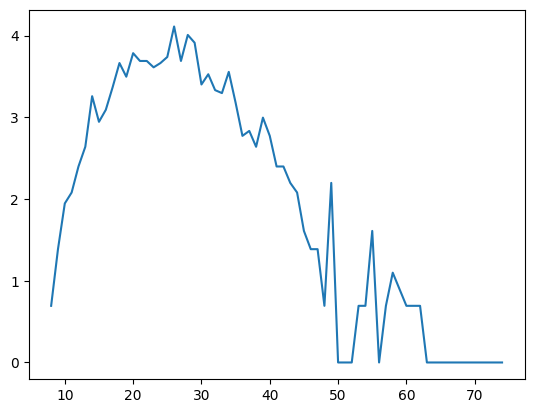

In [8]:
import math
plt.plot([x[0] for x in src_len_fre], [math.log(x[1]) for x in src_len_fre])

In [9]:
sum(src_len)/len(src_len)

27.33102766798419

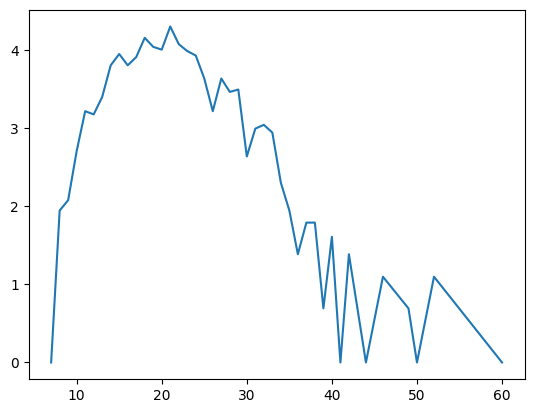

In [10]:
plt.plot([x[0] for x in tgt_len_fre], [math.log(x[1]) for x in tgt_len_fre])

In [11]:
sum(tgt_len)/len(tgt_len)

21.641304347826086

In [4]:
checkpoint = "/public/home/hongy/hyxu/nmt-corrector/checkpoint-nmt/mbart50/checkpoint-30000"
checkpoint

'/public/home/hongy/hyxu/nmt-corrector/checkpoint-nmt/mbart50/checkpoint-30000'

In [5]:
from transformers import MBart50Tokenizer
tokenizer = MBart50Tokenizer.from_pretrained(checkpoint)
tokenizer

PreTrainedTokenizer(name_or_path='/public/home/hongy/hyxu/nmt-corrector/checkpoint-nmt/mbart50/checkpoint-30000', vocab_size=250054, model_max_len=1024, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>', 'additional_special_tokens': ['ar_AR', 'cs_CZ', 'de_DE', 'en_XX', 'es_XX', 'et_EE', 'fi_FI', 'fr_XX', 'gu_IN', 'hi_IN', 'it_IT', 'ja_XX', 'kk_KZ', 'ko_KR', 'lt_LT', 'lv_LV', 'my_MM', 'ne_NP', 'nl_XX', 'ro_RO', 'ru_RU', 'si_LK', 'tr_TR', 'vi_VN', 'zh_CN', 'af_ZA', 'az_AZ', 'bn_IN', 'fa_IR', 'he_IL', 'hr_HR', 'id_ID', 'ka_GE', 'km_KH', 'mk_MK', 'ml_IN', 'mn_MN', 'mr_IN', 'pl_PL', 'ps_AF', 'pt_XX', 'sv_SE', 'sw_KE', 'ta_IN', 'te_IN', 'th_TH', 'tl_XX', 'uk_UA', 'ur_PK', 'xh_ZA', 'gl_ES', 'sl_SI']})

In [6]:
tokenizer.src_lang, tokenizer.tgt_lang

('ur_PK', 'en_XX')

In [7]:
tokenizer.src_lang, tokenizer.tgt_lang = 'ur_PK', 'en_XX'

In [8]:
tokenized_datasets = get_tokenized_datasets(tokenizer, trans_para=dataset, 
                                            src_lang=f"sentence_{src_code}", tgt_lang=f"sentence_{tgt_code}",
                                            max_input_length=256, max_target_length=256)
tokenized_datasets

Loading cached processed dataset at /public/home/hongy/.cache/huggingface/datasets/flores/urd_Arab-eng_Latn/1.0.0/2a1174c8c4991ca09a9cb5b9a367cb2e049b073852cb4097456164d4612391ef/cache-532194607cd1a334.arrow
Loading cached processed dataset at /public/home/hongy/.cache/huggingface/datasets/flores/urd_Arab-eng_Latn/1.0.0/2a1174c8c4991ca09a9cb5b9a367cb2e049b073852cb4097456164d4612391ef/cache-a6792f17b2add9ea.arrow


DatasetDict({
    dev: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 997
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1012
    })
})

In [9]:
training_args = Seq2SeqTrainingArguments(output_dir='../log/',
                                         generation_max_length=256,
                                         generation_num_beams=1,
                                         per_gpu_eval_batch_size=64,
                                         fp16=True,
                                         )
# training_args

In [10]:
model = MBartForConditionalGeneration.from_pretrained(checkpoint)
model

MBartForConditionalGeneration(
  (model): MBartModel(
    (shared): Embedding(250054, 1024, padding_idx=1)
    (encoder): MBartEncoder(
      (embed_tokens): Embedding(250054, 1024, padding_idx=1)
      (embed_positions): MBartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0): MBartEncoderLayer(
          (self_attn): MBartAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerN

In [3]:
import numpy as np
import evaluate
metric = evaluate.load("sacrebleu", tokenize="flores200")
metric

EvaluationModule(name: "sacrebleu", module_type: "metric", features: [{'predictions': Value(dtype='string', id='sequence'), 'references': Sequence(feature=Value(dtype='string', id='sequence'), length=-1, id='references')}, {'predictions': Value(dtype='string', id='sequence'), 'references': Value(dtype='string', id='sequence')}], usage: """
Produces BLEU scores along with its sufficient statistics
from a source against one or more references.

Args:
    predictions (`list` of `str`): list of translations to score. Each translation should be tokenized into a list of tokens.
    references (`list` of `list` of `str`): A list of lists of references. The contents of the first sub-list are the references for the first prediction, the contents of the second sub-list are for the second prediction, etc. Note that there must be the same number of references for each prediction (i.e. all sub-lists must be of the same length).
    smooth_method (`str`): The smoothing method to use, defaults to `'e

In [10]:
import torch
def compute_metrics(eval_preds):
    
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = torch.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_lables = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_lablels = [[label.strip()] for label in decoded_lables]

    result = metric.compute(predictions=decoded_preds, references=decoded_lablels)
    return {'bleu': result['score']}

In [13]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    data_collator=DataCollatorForSeq2Seq(tokenizer, model, padding=True, max_length=256),
    compute_metrics=compute_metrics,
)

Using cuda_amp half precision backend


# 保存flores的dev和test数据

In [ ]:
from datasets import load_dataset, Dataset
lang_pairs = {"en-ur": ("urd_Arab", "eng_Latn"), "en-tr": ("tur_Latn", "eng_Latn")}
path = "../data/"
data_dir = "../../flores/"
for k, v in lang_pairs:
    save_dir = os.path.join(path, k)
    lang1, lang2 = v
    dataset_dev_test = load_dataset(data_dir, f"{lang1}-{lang2}")
    dev = dataset_dev_test.pop("dev")
    test = dataset_dev_test.pop("test")
    dev

In [5]:
from datasets import load_dataset, Dataset
data_dir = "../../flores/"
dataset_dev_test = load_dataset(data_dir, f"tur_Latn-eng_Latn")
dataset_dev_test

Found cached dataset flores (/public/home/hongy/.cache/huggingface/datasets/flores/tur_Latn-eng_Latn/1.0.0/2a1174c8c4991ca09a9cb5b9a367cb2e049b073852cb4097456164d4612391ef)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    dev: Dataset({
        features: ['id', 'URL', 'domain', 'topic', 'has_image', 'has_hyperlink', 'sentence_tur_Latn', 'sentence_eng_Latn'],
        num_rows: 997
    })
    devtest: Dataset({
        features: ['id', 'URL', 'domain', 'topic', 'has_image', 'has_hyperlink', 'sentence_tur_Latn', 'sentence_eng_Latn'],
        num_rows: 1012
    })
})

In [7]:
src_lang_code, tgt_lang_code = "tur_Latn", "eng_Latn"
data = dataset_dev_test['devtest'].to_dict()
data = {src_lang_code: data[f"sentence_{src_lang_code}"], tgt_lang_code: data[f"sentence_{tgt_lang_code}"]}
data

{'tur_Latn': ['Daha önce diyabetik olup şimdi diyabetik olmayan 4 aylık farelerimiz var, diye ekledi.',
  "Halifax, Nova Scotia'daki Dalhousie Üniversitesi'nde tıp profesörü ve Kanada Diyabet Derneği'nin klinik ve bilim alanı başkanı olan Dr. Ehud Ur, çalışmanın henüz başlangıç aşamasında olduğu konusunda uyarıda bulundu.",
  'Bazı diğer uzmanlar gibi o da, bu bulguların zaten Tip 1 diyabeti olan kişilerle bir ilişkisi olmadığına dikkat çekerek diyabetin tedavi edilebileceği ile ilgili şüpheci kalmıştır.',
  "İsveç Akademisi Nobel Edebiyat Komitesi'nin daimi sekreteri Sara Danius, İsveç'teki Sveriges Radyosu'ndaki bir radyo programında, komitenin 2016 Nobel Edebiyat Ödülü'nü kazanma konusunda Bob Dylan'a doğrudan ulaşamadığını, ona ulaşma çabalarından vazgeçtiğini duyurdu.",
  'Danius dedi ki, "Şu anda hiçbir şey yapmıyoruz. En yakın iş ortağını aradım ve e-postalar yolladım, çok samimi cevaplar aldım. Şu an için bu ziyadesiyle kafi."',
  "Daha önce, Ring'in CEO'su Jamie Siminoff şirke

In [8]:
len(data[src_lang_code]), len(data[tgt_lang_code])
src_data = [s+"\n"for s in data[src_lang_code]]
tgt_data = [s+"\n"for s in data[tgt_lang_code]]

(1012, 1012)

In [8]:
from utils import save_flores_test_as_file
save_flores_test_as_file("/public/home/hongy/hyxu/nmt-corrector/data/en-be", "bel_Cyrl", "eng_Latn", "bin")

Generating dev split: 0 examples [00:00, ? examples/s]

Generating devtest split: 0 examples [00:00, ? examples/s]

Dataset flores downloaded and prepared to /public/home/hongy/.cache/huggingface/datasets/flores/bel_Cyrl-eng_Latn/1.0.0/2a1174c8c4991ca09a9cb5b9a367cb2e049b073852cb4097456164d4612391ef. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
import torch
torch.load("../data/en-be/flores.bel-eng-test.bin")[:10]

[{"src": "«У нас зараз ёсць 4-месячныя мышы без дыябету, якія раней хварэлі на дыябет», — дадаў ён.", "ref": "\"We now have 4-month-old mice that are non-diabetic that used to be diabetic,\" he added.", "pre": null, "cor": null},
 {"src": "Згодна з папярэджаннем старшыні клінічнага і навуковага падраздзялення Канадскай асацыяцыі хворых на дыябет і прафесара медыцыны з Універсітэта Дэлхаўзі ў Галіфаксе (Новая Шатландыя) доктара Эхуда Ура даследаванне ўсё яшчэ знаходзіцца на раннім этапе.", "ref": "Dr. Ehud Ur, professor of medicine at Dalhousie University in Halifax, Nova Scotia and chair of the clinical and scientific division of the Canadian Diabetes Association cautioned that the research is still in its early days.", "pre": null, "cor": null},
 {"src": "Ён скептычна ставіцца да магчымасці вылечыць дыябет, як і некаторыя другія эксперты, кажучы, што згаданыя вынікі не маюць ніякага дачынення да тых, хто ўжо хварэе на цукровы дыябет 1 тыпу.", "ref": "Like some other experts, he is ske

In [4]:
from utils import save_flores_test_as_file
save_flores_test_as_file("/public/home/hongy/hyxu/nmt-corrector/data/en-az", "azb_Arab", "eng_Latn", "bin")

Found cached dataset flores (/public/home/hongy/.cache/huggingface/datasets/flores/azb_Arab-eng_Latn/1.0.0/2a1174c8c4991ca09a9cb5b9a367cb2e049b073852cb4097456164d4612391ef)


  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
import torch
data = torch.load("../data/en-az/flores.azb-eng-test.bin")
len(data)
data[:10]

[{"src": "او اضافه الیدی کی: \"ایندی 4 آیلیق قاباقجان دیابتلی، آما ایندی دیابتسیز سیچانلاریمیز وار\".", "ref": "\"We now have 4-month-old mice that are non-diabetic that used to be diabetic,\" he added.", "pre": null, "cor": null},
 {"src": "نوا اسکوشیا اوستانیندا، هالیفاکس شهرینده دالهاوزی دانیشگاهینین پزشکی استادی و کانادانین دیابت انجمنینین علمی و کلینیکی بخشینین رئیسی، دوهتور اهود اور، هشدار وردی کی بو تحقیقین هله اول گونلریدی.", "ref": "Dr. Ehud Ur, professor of medicine at Dalhousie University in Halifax, Nova Scotia and chair of the clinical and scientific division of the Canadian Diabetes Association cautioned that the research is still in its early days.", "pre": null, "cor": null},
 {"src": "آیری متخصصلر کیمی، او دیابتین درمانیندان مطمئن دییر و تاکید ائلییر کی بو تحقیقدن اله گلن نتیجه لر ۱اینجی نوع دیابتی اولانلارا تاثیری یوخدی.", "ref": "Like some other experts, he is skeptical about whether diabetes can be cured, noting that these findings have no relevance to people who al

In [29]:
import torch
data = torch.load("../data/src-ref-pre/ka-en-flores-test/thread0/paras-0.bin")
data[5].pre = "his doorbell wasn't audible from his shop in his garage."
torch.save(data, "../data/src-ref-pre/ka-en-flores-test/thread0/paras-0.bin")

# 保存c4的单语数据

In [1]:
from datasets import load_dataset

# mc4_subset = load_dataset("mc4", languages=["az", "ka"])
mc4_subset = load_dataset("mc4", "ka")
mc4_subset

Found cached dataset mc4 (/public/home/hongy/.cache/huggingface/datasets/mc4/ka/0.0.0/99acea4a740b4cc36e4a93a238c7de11b0ce341d65b7d37168b3b90fd64721d2)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'timestamp', 'url'],
        num_rows: 2295551
    })
    validation: Dataset({
        features: ['text', 'timestamp', 'url'],
        num_rows: 2279
    })
})

## 处理ka的单语数据

In [2]:
mc4_ka_first_50w = mc4_subset['train'][:500000]
mono = mc4_ka_first_50w['text']
len(mono), mono[:10]

(500000,
 ['რუსეთის პრესის მიმოხილვა. 2017 წლის 19 აპრილი\n„გზა აჩვენებს“ - ამ სათაურით გამოაქვეყნა „კომერსანტმა“ სტატია, რომელშიც საუბარია როგორც ცხინვალში გამართული არჩევნებისა და რეფერენდუმის შესახებ, ასევე რუსეთის საგარეო საქმეთა მინისტრის ვიზიტზე სოხუმში. სტატიის თანახმად, თვითაღიარებულ რესპუბლიკაში გამართულ არჩევნებში გაიმარჯვა იმ კანდიდატმა, რომლის საქმიანობასაც უკავშირდება რუსეთის შემადგენლობაში შესვლის მეტი იმედი. რეალურად, არანაირი საარჩევნო პროგრამა, რომელშიც ამომრჩეველთა სოციალურ-ეკონომიკური მდგომარეობის გაუმჯობესების გეგმა იქნებოდა ჩამოყალიბებული, გამარჯვებულ კანდიდატს, ანატოლი ბიბილოვს, არ ჰქონია. მთელი იმედი დამყარებულია რუსეთთან მჭიდრო ინტეგრაციაზე, თუმცა, როგორც სტატიის ავტორი შენიშნავს, სამხრეთ ოსეთის მიღებას რუსეთის შემადგენლობაში მოჰყვება საერთაშორისო თანამეგობრობის ნეგატიური რეაქცია და ურთიერთობის სრული გაწყვეტა საქართველოსთან, მაშინ როცა ამ ურთიერთობაზე დამოკიდებულია რეგიონში რუსეთის ერთადერთი გეოპოლიტიკური მოკავშირის, სომხეთის, ბედი. რუსეთის სომხეთთან დამაკავშირე

In [4]:
from tqdm import tqdm
sentences = []
splits = ("\n","\t",".","!","?")
for m in tqdm(mono):
    res = [m]
    for span in splits:
        tmp = []
        for s in res:
            tmp += [i for i in s.split(span) if len(i.split(" "))>7]
        res = tmp
    sentences += res
len(sentences), sentences[:20]

100%|██████████| 500000/500000 [01:20<00:00, 6234.13it/s]


(9935555,
 ['„გზა აჩვენებს“ - ამ სათაურით გამოაქვეყნა „კომერსანტმა“ სტატია, რომელშიც საუბარია როგორც ცხინვალში გამართული არჩევნებისა და რეფერენდუმის შესახებ, ასევე რუსეთის საგარეო საქმეთა მინისტრის ვიზიტზე სოხუმში',
  ' სტატიის თანახმად, თვითაღიარებულ რესპუბლიკაში გამართულ არჩევნებში გაიმარჯვა იმ კანდიდატმა, რომლის საქმიანობასაც უკავშირდება რუსეთის შემადგენლობაში შესვლის მეტი იმედი',
  ' რეალურად, არანაირი საარჩევნო პროგრამა, რომელშიც ამომრჩეველთა სოციალურ-ეკონომიკური მდგომარეობის გაუმჯობესების გეგმა იქნებოდა ჩამოყალიბებული, გამარჯვებულ კანდიდატს, ანატოლი ბიბილოვს, არ ჰქონია',
  ' მთელი იმედი დამყარებულია რუსეთთან მჭიდრო ინტეგრაციაზე, თუმცა, როგორც სტატიის ავტორი შენიშნავს, სამხრეთ ოსეთის მიღებას რუსეთის შემადგენლობაში მოჰყვება საერთაშორისო თანამეგობრობის ნეგატიური რეაქცია და ურთიერთობის სრული გაწყვეტა საქართველოსთან, მაშინ როცა ამ ურთიერთობაზე დამოკიდებულია რეგიონში რუსეთის ერთადერთი გეოპოლიტიკური მოკავშირის, სომხეთის, ბედი',
  ' რუსეთის სომხეთთან დამაკავშირებელი ერთადერთი სახმელეთო მ

In [5]:
sentences = [s.lstrip(" ").rstrip(" ") for s in sentences if 50>len(s.split(" "))>8]
len(sentences)

8760337

以下是一个Python示例代码，可以使用正则表达式计算一条句子中英文字符和非法符号的个数：

```python
import re

# 句子文本
text = "Hello，你好！这里有一些非法符号：@#$%^&*()。"

# 匹配英文字符和非法符号
pattern = re.compile(r'[^\u4e00-\u9fa5\uFF00-\uFFEF\s]')

# 计算匹配到的字符数量
matches = pattern.findall(text)
english_count = len(matches)
symbol_count = len(re.findall(r'[^\u4e00-\u9fa5\uFF00-\uFFEF\s\w]', text))

# 输出结果
print("英文字符数量：", english_count)
print("非法符号数量：", symbol_count)
```

这个代码片段使用正则表达式模式来匹配英文字符和非法符号。英文字符是指不包括中文字符和标点符号的其他字符，
模式是`[^\u4e00-\u9fa5\uFF00-\uFFEF\s]`。非法符号的模式是`[^\u4e00-\u9fa5\uFF00-\uFFEF\s\w]`即非中文字符、空格、字母或数字的字符。最后使用`findall()`函数计算匹配到的英文字符和非法符号的数量。

In [26]:
import re

def count_eng(text):
    pattern = re.compile(r'[^\u4e00-\u9fa5\uFF00-\uFFEF\s]')

# 计算匹配到的字符数量
    english_count = len(re.findall(r'[a-zA-Z@#$%&*0-9]', text))
    # symbol_count = len(re.findall(r'[^\u4e00-\u9fa5\uFF00-\uFFEF\s\w]', text))
    return english_count
results_sentences = []
results_sentences = [s for s in sentences if count_eng(s)/len(s) < 0.1]
len(results_sentences)

7602550

In [27]:
results_sentences = [s+"\n" for s in results_sentences[500000:]]
with open("../data/mono/ka/760-filter.ka", 'w')as f:
    f.writelines(results_sentences)

In [7]:
results_sentences = []
with open("../data/mono/ka/760-filter.ka", 'r')as f:
    results_sentences = f.readlines()
len(results_sentences)

7102550

In [4]:
import re
def count_r_ger(text):
    """统计非格鲁尼亚语言的个数"""
    pattern = re.compile(r'[^\u10A0-\u10FF\u2D00-\u2D2F\s]')
    r_ger_count = len(re.findall(pattern, text))
    return r_ger_count
count_r_ger("ـــوه ی نـوشـتـــن مـتـــ#ن بـا قـلـــم زیـبـــا و اصـیـــل نـسـتـــعـلـیـელი იქნება ახალი მასალის ეფექტური პრეზენტაც")

65

In [5]:
with open("../data/mono/ka/760-filter.ka", 'r') as f:
    sentences = f.readlines()
sentences = [s.rstrip("\n") for s in sentences if len(s)>3]
len(sentences)

7102550

In [11]:
results_sentences = [s+"\n" for s in sentences if count_r_ger(s)/len(s)<0.1]
len(results_sentences)

6695670

In [12]:
results_sentences = [s for s in results_sentences if len(s.split(" "))>10]
len(results_sentences)

5032301

In [13]:
results_sentences[:10]

['შინაგან საქმეთა სამინისტროსავე ოფიციალურ ვებსაიტზე გამოქვეყნებული მონაცემებით, 2017 წელს სასამართლომ დაამტკიცა პოლიციის მიერ გამოცემული 4 370 შემაკავებელი ორდერი\n',
 'შარშან დაფიქსირებული იყო ოჯახში ძალადობის 2 192 შემთხვევა და მათგან 73 %–ზე დაიწყო დევნა\n',
 '2017 წელს იმერეთსა და რაჭა ლეჩხუმში გამოვლინდა ოჯახში ძალადობის 428 შემთხვევა და მათგან 9 ფატალურად დასრულდა\n',
 'სტატისტიკური მონაცემების ზრდას ორ ფაქტორს უკავშირებს „საქართველოს ახალგაზრდა იურისტთა ასოციაციის“ ქუთაისის ოფისის ხელმძღვანელი ზაალ გორგიძე\n',
 'მისი განცხადებით, ერთი მხრივ, რეალურად გაიზარდა ოჯახში ძალადობის ფაქტები და, ამასთან, შეიცვალა ადამიანების ცნობიერება და დიდი ნაწილი აღარ ცდილობს დამალოს ოჯახში ძალადობის ფაქტი\n',
 'ზაალ გორგიძისავე განცხადებით, მიუხედავად იმისა, რომ ბოლო 12 წლის განმავლობაში - მას შემდეგ, რაც ქვეყანაში ამოქმედდა „ოჯახში ძალადობის აღკვეთის, ოჯახში ძალადობის მსხვერპლთა დაცვისა და დახმარების შესახებ“ კანონი - საზოგადოებაში დამოკიდებულება შეიცვალა და ოჯახში ძალადობა დანაშაულად აღიქმება, თ

In [14]:
with open("../data/mono/ka/d50-filter.ka", "w") as f:
    f.writelines(results_sentences[:500000])
with open("../data/mono/ka/450-filter.ka", "w") as f:
    f.writelines(results_sentences[500000:])

In [15]:
with open("../data/mono/ka/450-filter.ka", "r") as f:
    data = f.readlines()
len(data), data[:20]

(4532301,
 ['მომდევნო რაუნდში გასვლა გვინდა და მთლიანად მატჩზე ვართ კონცენტრირებულნი, რადგან როგორც აქამდე ვთქვი, გუნდი ამ ტურნირს სერიოზულად ეკიდება\n',
  '"ლესტერის" წინააღმდეგ პირველ ტაიმში ჩვენი შანსების გამოყენება მოვახერხეთ, რამაც საშუალება მოგვცა მშვიდი შეხვედრა ჩაგვეტარებინა და მისგან უფრო მეტი სიამოვნება მიგვეღო, ვიდრე ბოლო კვირებში\n',
  'სეზონის ამ დროს ისეთი მონდომებული უნდა ვიყოთ, როგორც არასდროს, რათა სამეულში ადგილის შენარჩუნება და მეორე ადგილთან მოახლოვება შევძლოთ\n',
  'S მინდა ჩემს მეგობარს, ანდერსონს, წარმატება ვუსურვო, რომელიც სამშობლოში დაბრუნდა ფეხბურთის სათამაშოდ\n',
  'ერერა,მატა, იანუზაი, ლინგარდი - მინდე ეს მოთამაშეები ვიხილო კემბრიჯთან და წინ ფალკაო, რადგან მასსაც სჭირდება მუდმივი პრაქტიკა\n',
  'რა თქმა უნდა, დაუფასებლობა არ ღირს, მაგრამ მაინც იმედი მაქვს იოლად გავუმკლავდებით\n',
  'კემბრიჯმა უკვე დაამტკიცა რომ ხელწამოსაკრავი მეტოქე არ არის და ამ მატჩს ნამდვილად სერიოზულად უნდა მოეკიდონ\n',
  'არამგონია ეგ ყველა გამოუშვას, იმიტომ რომ რთული შეხვედრაა იქნება ნ

In [20]:
import evaluate
compute_ter = evaluate.load("ter")
# ივანე ჯავახიშვილის სახელობის თბილისის სახელმწიფო უნივერსიტეტის რექტორის, პროფესორ გიორგი ხუბუას ბრძანება სტუდენტთა საუნივერსიტეტო სამეცნიერო კონფერენციის ჩატარების შესახებ (ბრძანება N18/01–01)
# ივანე ჯავახიშვილის სახელობის თბილისის სახელმწიფო უნივერსიტეტის რექტორის, პროფესორ გიორგი ხუბუას ბრძანება 2006-2007 სასწავლო წლის საგაზაფხულო სემესტრში სტუდენტთა რეგისტრაციისათვის გასატარებელ ღონისძიებათა შესახებ (ბრძანება N14/01–01)
# ივანე ჯავახიშვილის სახელობის თბილისის სახელმწიფო უნივერსიტეტის რექტორის, პროფესორ გიორგი ხუბუას ბრძანება ივანე ჯავახიშვილის სახელობის თბილისის სახელმწიფო უნივერსიტეტის ჰუმანიტარული ფაკულტეტის ენების შემსწავლელი ცენტრის პედაგოგთა დანიშვნის შესახებ (ბრძანება N03/01–03)
# ივანე ჯავახიშვილის სახელობის თბილისის სახელმწიფო უნივერსიტეტის რექტორის, პროფესორ გიორგი ხუბუას ბრძანება უნივერსიტეტის ფაკულტეტის სასწავლო პროგრამით გათვალისწინებული სასწავლო დისციპლინების განმეორებით მოსმენის პროცესის მოწესრიგების შესახებ (ბრძანება N13/01–01)
# ივანე ჯავახიშვილის სახელობის თბილისის სახელმწიფო უნივერსიტეტის ადმინისტრაციის ხელმძღვანელის, გულნაზი გალდავას ბრძანება უნივერსიტეტის ადმინისტრაციის თანამშრომელთა ატესტაციის ჩატარების ღონისძიებათა განხორციელების უზრუნველყოფის შესახებ (ბრძანება N06/02–01)
pre=["ივანე ჯავახიშვილის სახელობის თბილისის სახელმწიფო უნივერსიტეტის რექტორის, პროფესორ გიორგი ხუბუას ბრძანება სტუდენტთა საუნივერსიტეტო სამეცნიერო კონფერენციის ჩატარების შესახებ (ბრძანება N18/01–01)"]
ref=[["ივანე ჯავახიშვილის სახელობის თბილისის სახელმწიფო უნივერსიტეტის რექტორის, პროფესორ გიორგი ხუბუას ბრძანება 2006-2007 სასწავლო წლის საგაზაფხულო სემესტრში სტუდენტთა რეგისტრაციისათვის გასატარებელ ღონისძიებათა შესახებ (ბრძანება N14/01–01)"]]
sores = compute_ter.compute(predictions=pre,references=ref, case_sensitive=False)
sores

{'score': 43.47826086956522, 'num_edits': 10, 'ref_length': 23.0}

In [31]:
from tqdm import tqdm
import evaluate
compute_ter = evaluate.load("ter")
results_sentences = [data[i] for i in range(2)]
for i in tqdm(range(2, len(data))):
    sores = compute_ter.compute(predictions=[data[i]], references=[[data[i-1], data[i-2]]], case_sensitive=False)
    if sores["score"] > 55:
        results_sentences.append(data[i])

100%|██████████| 4532299/4532299 [9:16:07<00:00, 135.83it/s]   


In [33]:
len(results_sentences), len(data)

(4417059, 4532301)

In [38]:
with open("../data/mono/ka/450-filter.ka", "r") as f:
    data = f.readlines()
len(data), data[:12]

(4417059,
 ['მომდევნო რაუნდში გასვლა გვინდა და მთლიანად მატჩზე ვართ კონცენტრირებულნი, რადგან როგორც აქამდე ვთქვი, გუნდი ამ ტურნირს სერიოზულად ეკიდება\n',
  '"ლესტერის" წინააღმდეგ პირველ ტაიმში ჩვენი შანსების გამოყენება მოვახერხეთ, რამაც საშუალება მოგვცა მშვიდი შეხვედრა ჩაგვეტარებინა და მისგან უფრო მეტი სიამოვნება მიგვეღო, ვიდრე ბოლო კვირებში\n',
  'სეზონის ამ დროს ისეთი მონდომებული უნდა ვიყოთ, როგორც არასდროს, რათა სამეულში ადგილის შენარჩუნება და მეორე ადგილთან მოახლოვება შევძლოთ\n',
  'S მინდა ჩემს მეგობარს, ანდერსონს, წარმატება ვუსურვო, რომელიც სამშობლოში დაბრუნდა ფეხბურთის სათამაშოდ\n',
  'ერერა,მატა, იანუზაი, ლინგარდი - მინდე ეს მოთამაშეები ვიხილო კემბრიჯთან და წინ ფალკაო, რადგან მასსაც სჭირდება მუდმივი პრაქტიკა\n',
  'რა თქმა უნდა, დაუფასებლობა არ ღირს, მაგრამ მაინც იმედი მაქვს იოლად გავუმკლავდებით\n',
  'კემბრიჯმა უკვე დაამტკიცა რომ ხელწამოსაკრავი მეტოქე არ არის და ამ მატჩს ნამდვილად სერიოზულად უნდა მოეკიდონ\n',
  'არამგონია ეგ ყველა გამოუშვას, იმიტომ რომ რთული შეხვედრაა იქნება ნ

In [39]:
with open("../data/mono/ka/d50-filter.ka", "w") as f:
    f.writelines(data[1000000:1500000])

## 处理az的单语数据

In [15]:
from datasets import load_dataset

# mc4_subset = load_dataset("mc4", languages=["az", "ka"])
mc4_subset = load_dataset("mc4", "az")
mc4_subset

Found cached dataset mc4 (/public/home/hongy/.cache/huggingface/datasets/mc4/az/0.0.0/99acea4a740b4cc36e4a93a238c7de11b0ce341d65b7d37168b3b90fd64721d2)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'timestamp', 'url'],
        num_rows: 5285720
    })
    validation: Dataset({
        features: ['text', 'timestamp', 'url'],
        num_rows: 5239
    })
})

In [16]:
mc4_az_first_50w = mc4_subset['train'][:500000]
mono = mc4_az_first_50w['text']
len(mono), mono[:10]

(500000,
 ['Mühacirət mövzusunun öyrənilməsi ictimai-siyasi fikrin zənginləşməsinə xidmət edir - AZƏRTAC – Azərbaycan Dövlət İnformasiya Agentliyi\nNoyabrın 6-da Azərbaycan Dövlət Pedaqoji Universiteti (ADPU) Rusiya Dövlət Humanitar Universiteti (RDHU) ilə birgə “1917-1920-ci illərin mühacirətinin öyrənilməsinin və tədrisinin müasir meyilləri” mövzusunda beynəlxalq elmi-praktik seminar keçirib.\nADPU-dan AZƏRTAC-a bildirilib ki, beynəlxalq seminar “Vətən tarixi” Fondunun dəstəyi ilə “Rusiya mühacirətinin birinci dalğası Avropa ölkələrinin və xalqlarının tarix və mədəniyyətində” layihəsi çərçivəsində reallaşıb.\nADPU-nun rektoru, professor Cəfər Cəfərov rəhbərlik etdiyi universitetin uğurları haqqında məlumat verib. Qeyd edib ki, bu il 566 nəfər gənc 500-dən çox bal toplayaraq ali təhsil almaq üçün Pedaqoji Universiteti seçib. Bu, əvvəlki illərlə müqayisədə çox yüksək göstəricidir. 100 illik yubileyini qeyd etməyə hazırlaşan universitet ölkəmizin aparıcı ali təhsil müəssisələrindən biri

In [17]:
from tqdm import tqdm
sentences = []
splits = ("\n","\t",".","!","?")
for m in tqdm(mono):
    res = [m]
    for span in splits:
        tmp = []
        for s in res:
            lst = [i.lstrip(" ").rstrip(" ") for i in s.split(span)]
            tmp += [i for i in lst if len(i.split(" "))>8]
        res = tmp
    sentences += res
len(sentences), sentences[:20]

100%|██████████| 500000/500000 [01:17<00:00, 6437.35it/s]


(7178861,
 ['Mühacirət mövzusunun öyrənilməsi ictimai-siyasi fikrin zənginləşməsinə xidmət edir - AZƏRTAC – Azərbaycan Dövlət İnformasiya Agentliyi',
  'Noyabrın 6-da Azərbaycan Dövlət Pedaqoji Universiteti (ADPU) Rusiya Dövlət Humanitar Universiteti (RDHU) ilə birgə “1917-1920-ci illərin mühacirətinin öyrənilməsinin və tədrisinin müasir meyilləri” mövzusunda beynəlxalq elmi-praktik seminar keçirib',
  'ADPU-dan AZƏRTAC-a bildirilib ki, beynəlxalq seminar “Vətən tarixi” Fondunun dəstəyi ilə “Rusiya mühacirətinin birinci dalğası Avropa ölkələrinin və xalqlarının tarix və mədəniyyətində” layihəsi çərçivəsində reallaşıb',
  'ADPU-nun rektoru, professor Cəfər Cəfərov rəhbərlik etdiyi universitetin uğurları haqqında məlumat verib',
  'Qeyd edib ki, bu il 566 nəfər gənc 500-dən çox bal toplayaraq ali təhsil almaq üçün Pedaqoji Universiteti seçib',
  '100 illik yubileyini qeyd etməyə hazırlaşan universitet ölkəmizin aparıcı ali təhsil müəssisələrindən biridir',
  'Universitetin beynəlxalq əla

In [18]:
import re

def count_azb(text):
    pattern = re.compile(r'[^\u0600-\u06FF\u0750-\u077F\uFB50-\uFDFF\uFE70-\uFEFF\s]')

# 计算匹配到的字符数量
    r_azb_count = len(re.findall(pattern, text))
    # symbol_count = len(re.findall(r'[^\u4e00-\u9fa5\uFF00-\uFFEF\s\w]', text))
    return r_azb_count
results_sentences = []
# sentences = []
results_sentences = [s for s in sentences if count_azb(s)/len(s) < 0.1]
len(results_sentences)

71617

In [6]:
results_sentences = [s+"\n" for s in results_sentences]
with open("../data/mono/az/50-filter.ka", 'w') as f:
    f.writelines(results_sentences)

In [14]:
import nltk
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     /public/home/hongy/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
segment_results = []

In [19]:
sentences = nltk.sent_tokenize(mono[9], language="qwe")
sentences

LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/PY3/qwe.pickle[0m

  Searched in:
    - '/public/home/hongy/nltk_data'
    - '/public/home/hongy/miniconda3/envs/hyxu_env/nltk_data'
    - '/public/home/hongy/miniconda3/envs/hyxu_env/share/nltk_data'
    - '/public/home/hongy/miniconda3/envs/hyxu_env/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - ''
**********************************************************************


In [ ]:
from tqdm import tqdm
for s in tqdm(mono):
    segment_results += nltk.sent_tokenize(s)
len(segment_results)

In [23]:
import stanza

nlp = stanza.Pipeline(lang='ka', processors='tokenize')
doc = nlp('This is a test sentence for stanza. This is another sentence.')
for i, sentence in enumerate(doc.sentences):
    print(f'====== Sentence {i+1} tokens =======')
    print(*[f'id: {token.id}\ttext: {token.text}' for token in sentence.tokens], sep='\n')

2023-04-15 12:12:16 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-04-15 12:16:59 WARNING: Unsupported language: ka.


ValueError: No processors to load for language ka.  Please check if your language or package is correctly set.

## 自己写评估

In [11]:
model = model.cuda()
model.eval()
from tqdm import tqdm
bleu= []
dataloader = trainer.get_test_dataloader(tokenized_datasets['test'])
for step, x in tqdm(enumerate(dataloader)):
    for k in x:
        x[k] = x[k].cuda()
    outputs = model.generate(x['input_ids'], max_length=256)
    score = compute_metrics((outputs, x['labels']))
    bleu.append(score['bleu'])
    if step % 20 ==0:
        print(f"score is =>{score}")

len(bleu), sum(bleu)/len(bleu)

score is =>{'bleu': 0.13018659947291264}
score is =>{'bleu': 0.11864221013721646}
score is =>{'bleu': 0.11053717554587922}
score is =>{'bleu': 0.09463626463222698}


(64, 0.26190463742731906)

In [15]:
sum(bleu) / len(bleu)

1.8286503638611258

In [15]:
metric.compute(predictions=['I am a frog !',  ["我是一只青蛙"]], references=[['A frog am i !'], ["我是一只青蛙"]])

{'score': 10.511205190671433,
 'counts': [3, 0, 0, 0],
 'totals': [8, 6, 4, 2],
 'precisions': [37.5, 8.333333333333334, 6.25, 6.25],
 'bp': 1.0,
 'sys_len': 8,
 'ref_len': 6}

In [18]:
metric.compute(predictions=["我 是 一只 青蛙"], references=[ ["我 是 一只 青蛙"]])

{'score': 100.00000000000004,
 'counts': [4, 3, 2, 1],
 'totals': [4, 3, 2, 1],
 'precisions': [100.0, 100.0, 100.0, 100.0],
 'bp': 1.0,
 'sys_len': 4,
 'ref_len': 4}

In [15]:
sum(bleu) / len(bleu)

1.8413323465234162

# evaluate

In [14]:
trainer.evaluate(tokenized_datasets['dev'])

Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
***** Running Evaluation *****
  Num examples = 997
  Batch size = 64
/public/home/hongy/miniconda3/envs/hyxu_env/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2322: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


RuntimeError: CUDA out of memory. Tried to allocate 16.69 GiB (GPU 0; 39.59 GiB total capacity; 18.39 GiB already allocated; 12.02 GiB free; 23.63 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
trainer.evaluate(tokenized_datasets['test'])

Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
***** Running Evaluation *****
  Num examples = 1012
  Batch size = 2


RuntimeError: CUDA out of memory. Tried to allocate 8.99 GiB (GPU 0; 39.59 GiB total capacity; 29.28 GiB already allocated; 8.96 GiB free; 29.50 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## 在flore上评估模型 mbart50

In [2]:
from transformers import MBart50Tokenizer, MBartForConditionalGeneration, Seq2SeqTrainer, Seq2SeqTrainingArguments
from datasets import load_dataset
checkpoint = "../../../pre-train_model/mbart-large-50/"

In [3]:
model = MBartForConditionalGeneration.from_pretrained(checkpoint)
tokenizer = MBart50Tokenizer.from_pretrained(checkpoint)
model, tokenizer

(MBartForConditionalGeneration(
   (model): MBartModel(
     (shared): Embedding(250054, 1024, padding_idx=1)
     (encoder): MBartEncoder(
       (embed_tokens): Embedding(250054, 1024, padding_idx=1)
       (embed_positions): MBartLearnedPositionalEmbedding(1026, 1024)
       (layers): ModuleList(
         (0): MBartEncoderLayer(
           (self_attn): MBartAttention(
             (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
             (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
             (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
             (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
           )
           (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
           (activation_fn): GELUActivation()
           (fc1): Linear(in_features=1024, out_features=4096, bias=True)
           (fc2): Linear(in_features=4096, out_features=1024, bias=True)
           (final_

In [4]:
src_lang, tgt_lang = "ur_PK", "en_XX"
src_lang_code, tgt_lang_code = "urd_Arab", "eng_Latn"
tokenizer.src_lang = src_lang
tokenizer.tgt_lang =  tgt_lang
dataset = load_dataset("../../flores/", f"{src_lang_code}-{tgt_lang_code}")

Found cached dataset flores (/public/home/hongy/.cache/huggingface/datasets/flores/urd_Arab-eng_Latn/1.0.0/2a1174c8c4991ca09a9cb5b9a367cb2e049b073852cb4097456164d4612391ef)


  0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
import evaluate
metric = evaluate.load("sacrebleu", tokenize="flores200")

In [16]:
metric.compute(references=[["i am a frog !"]], predictions=["am i a frog !"], tokenize="flores200")

Tokenizer 'spm' has been changed to 'flores101', and may be removed in the future.


{'score': 56.234132519034915,
 'counts': [6, 3, 2, 1],
 'totals': [6, 5, 4, 3],
 'precisions': [100.0, 60.0, 50.0, 33.333333333333336],
 'bp': 1.0,
 'sys_len': 6,
 'ref_len': 6}

In [14]:
metric.tokenizer

AttributeError: 'Sacrebleu' object has no attribute 'tokenizer'

In [6]:
da = DataCollatorForSeq2Seq(tokenizer, model)

In [7]:
args = Seq2SeqTrainingArguments(
    "../",
    per_device_eval_batch_size=16,
)

trainer = Seq2SeqTrainer(model, args, tokenizer=tokenizer, data_collator=da, compute_metrics=get_compute_metrics)

In [8]:
dataset["test"] = dataset.pop("devtest")
dataset

DatasetDict({
    dev: Dataset({
        features: ['id', 'URL', 'domain', 'topic', 'has_image', 'has_hyperlink', 'sentence_urd_Arab', 'sentence_eng_Latn'],
        num_rows: 997
    })
    test: Dataset({
        features: ['id', 'URL', 'domain', 'topic', 'has_image', 'has_hyperlink', 'sentence_urd_Arab', 'sentence_eng_Latn'],
        num_rows: 1012
    })
})

In [9]:
tokenized_datasets = get_tokenized_datasets(tokenizer, dataset, f"sentence_{src_lang_code}", f"sentence_{tgt_lang_code}", 256,256)
tokenized_datasets

Loading cached processed dataset at /public/home/hongy/.cache/huggingface/datasets/flores/urd_Arab-eng_Latn/1.0.0/2a1174c8c4991ca09a9cb5b9a367cb2e049b073852cb4097456164d4612391ef/cache-2d7fb5f13b8fa6ad.arrow
Loading cached processed dataset at /public/home/hongy/.cache/huggingface/datasets/flores/urd_Arab-eng_Latn/1.0.0/2a1174c8c4991ca09a9cb5b9a367cb2e049b073852cb4097456164d4612391ef/cache-fe07bfecb48bdff0.arrow


DatasetDict({
    dev: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 997
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1012
    })
})

In [10]:
trainer.evaluate(tokenized_datasets['test'])

***** Running Evaluation *****
  Num examples = 1012
  Batch size = 16


RuntimeError: CUDA out of memory. Tried to allocate 12.13 GiB (GPU 0; 39.59 GiB total capacity; 13.43 GiB already allocated; 10.93 GiB free; 21.26 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## 看看 tanzil的句子的分布

In [12]:
from utils import (get_translate_paras_from_file,)

In [13]:
trans_paras = get_translate_paras_from_file("/public/home/hongy/hyxu/nmt-corrector/data/en-ur/Tanzil.en-ur.ur",
                                            "/public/home/hongy/hyxu/nmt-corrector/data/en-ur/Tanzil.en-ur.en")

In [14]:
src_len = [len(x.split(" ")) for x,_ in trans_paras]
tgt_len = [len(x.split(" ")) for _,x in trans_paras]
src_len_fre = Counter(src_len)
tgt_len_fre = Counter(tgt_len)

In [15]:
src_len_fre = sorted(src_len_fre.items(), key=lambda x: x[0])
tgt_len_fre = sorted(tgt_len_fre.items(), key=lambda x: x[0])

30.822301956382297

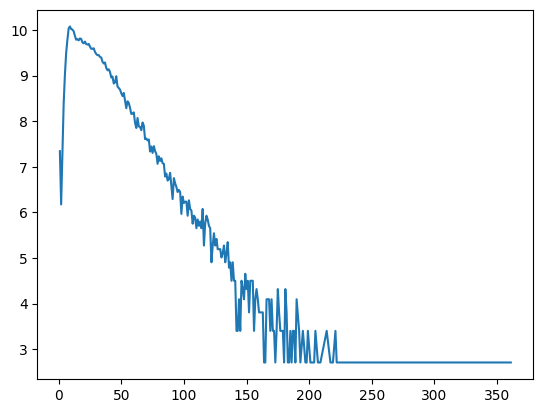

In [16]:
plt.plot([x[0] for x in src_len_fre], [math.log(x[1]) for x in src_len_fre])
sum(src_len) / len(src_len)

25.41026432542228

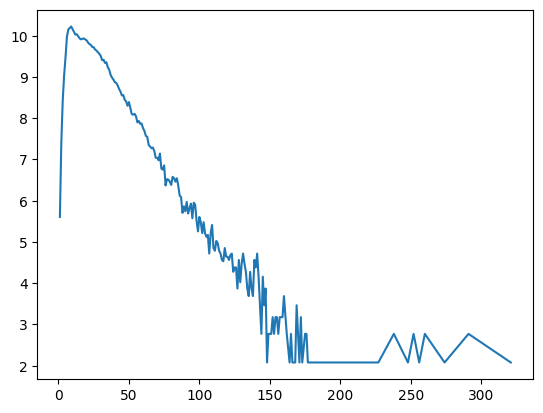

In [17]:
plt.plot([x[0] for x in tgt_len_fre], [math.log(x[1]) for x in tgt_len_fre])
sum(tgt_len) / len(tgt_len)

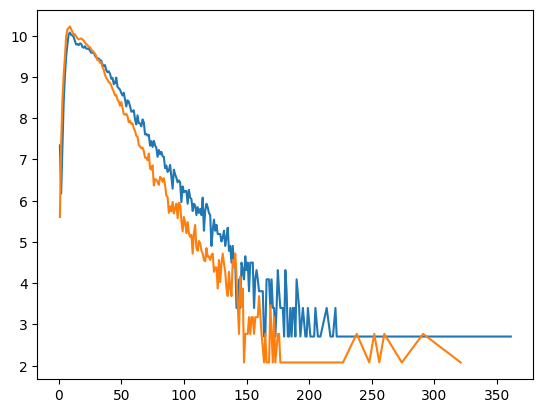

In [18]:
plt.plot([x[0] for x in src_len_fre], [math.log(x[1]) for x in src_len_fre])
plt.plot([x[0] for x in tgt_len_fre], [math.log(x[1]) for x in tgt_len_fre])

## 用BLEURT评估

In [1]:
import evaluate
bleurt = evaluate.load("bleurt")

ImportError: cannot import name 'score' from 'bleurt' (unknown location)

In [8]:
import os
import torch

# from utils import SrcRefPreCor
# data = torch.load("../data/src-ref-pre/ur-en-700000/4-24-first13w/thread0/paras-0.bin")
pre_data, cor_data = [], []
with open("../data/en-ur/pre20w-en-ur.en") as pre_f, open("../data/en-ur/20w.en-ur.en") as cor_f:
    pre_data = pre_f.readlines()
    cor_data = cor_f.readlines()
len(pre_data), len(cor_data)

(155654, 155654)

In [2]:
import os
import torch
from tqdm import tqdm
from utils import compute_bleu, compute_bleurt, compute_chrf, compute_ter
from bleurt_pytorch import BleurtConfig, BleurtForSequenceClassification, BleurtTokenizer
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [4]:
# config = BleurtConfig.from_pretrained('lucadiliello/BLEURT-20-D12')
# model = BleurtForSequenceClassification.from_pretrained('lucadiliello/BLEURT-20-D12')
model = BleurtForSequenceClassification.from_pretrained('lucadiliello/BLEURT-20')
# tokenizer = BleurtTokenizer.from_pretrained('lucadiliello/BLEURT-20-D12')
tokenizer = BleurtTokenizer.from_pretrained('lucadiliello/BLEURT-20')

references = ["a bird chirps by the window", "this is a random sentence"]
candidates = ["a bird chirps by the window", "this looks like a random sentence"]

model.eval()
with torch.no_grad():
    inputs = tokenizer(references, candidates, padding='longest', return_tensors='pt', truncation=True, max_length=512)
    res = model(**inputs).logits.flatten().tolist()
res

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BleurtSPTokenizer'. 
The class this function is called from is 'BertTokenizer'.


[0.9990501999855042, 0.7930180430412292]

In [7]:
def compute_bleurt(data_path, model, batch_size, results_pre, results_cor):
    results_pre, results_cor = [], []
    data = torch.load(data_path)
    data = [p for p in data if p.cor != None]
    num_steps = len(data) // batch_size if len(data) % batch_size == 0 else len(data) // batch_size + 1
    with torch.no_grad():
        for step in tqdm(range(num_steps)):
            compute_paras = data[step*batch_size:(step+1)*batch_size]
            ref = [p.ref for p in compute_paras]
            inputs = tokenizer(ref, [p.pre for p in compute_paras], 
                           padding='longest', return_tensors='pt', truncation=True, max_length=512)
            inputs = inputs.to(torch.device("cuda:0"))
            res_pre = model(**inputs).logits.flatten().tolist()
            inputs = tokenizer(ref, [p.cor for p in compute_paras], 
                           padding='longest', return_tensors='pt', truncation=True, max_length=512)
            inputs = inputs.to(torch.device("cuda:0"))
            res_cor = model(**inputs).logits.flatten().tolist()
        
            results_pre += res_pre
            results_cor += res_cor
    # print(f"第{step}步，{sum(results_pre)/len(results_pre)}")
    # print(f"第{step}步，{sum(results_cor)/len(results_cor)}")
    return results_pre, results_cor

In [8]:
model.eval()
model = model.cuda()
batch_size = 128
results_pre, results_cor = [], []
path = "../data/src-ref-pre/ur-en-700000/4-24-last10w/"
for file_path in os.listdir(path):
    if not file_path.startswith("thread"): continue
    
    id_thread = int(file_path[len("thread"):])
    data_path = os.path.join(path, file_path, f"paras-{id_thread}.bin")
    res_pre, res_cor = compute_bleurt(data_path ,model, batch_size, results_pre, results_cor)
    
    results_pre += res_pre
    results_cor += res_cor
    print(f"进程{id_thread}的pre平均分为{sum(res_pre) / len(res_pre)}   cor平均分为{sum(res_cor) / len(res_cor)}")
sum(results_pre) / len(results_pre), sum(results_cor) / len(results_cor)

100%|██████████| 66/66 [05:20<00:00,  4.86s/it]


进程1的pre平均分为0.5847909677222498   cor平均分为0.6014535718437762


100%|██████████| 66/66 [05:31<00:00,  5.03s/it]


进程10的pre平均分为0.6119766461596002   cor平均分为0.6130033397977126


100%|██████████| 66/66 [05:23<00:00,  4.89s/it]


进程11的pre平均分为0.6114962848096182   cor平均分为0.6132346221682722


100%|██████████| 66/66 [05:21<00:00,  4.87s/it]


进程2的pre平均分为0.601237827373498   cor平均分为0.6127232447307708


100%|██████████| 66/66 [05:04<00:00,  4.61s/it]


进程0的pre平均分为0.5807993708753534   cor平均分为0.6002476066583404


100%|██████████| 66/66 [04:24<00:00,  4.00s/it]


进程3的pre平均分为0.6208498416582277   cor平均分为0.618507398845203


100%|██████████| 66/66 [04:43<00:00,  4.29s/it]


进程4的pre平均分为0.6207134389428836   cor平均分为0.6200430579058809


100%|██████████| 66/66 [04:48<00:00,  4.38s/it]


进程5的pre平均分为0.6109564537105334   cor平均分为0.6319957997788047


100%|██████████| 66/66 [04:25<00:00,  4.02s/it]


进程6的pre平均分为0.6073239619160677   cor平均分为0.627815062698519


100%|██████████| 66/66 [04:54<00:00,  4.46s/it]


进程7的pre平均分为0.6127005481414545   cor平均分为0.6314358324273843


100%|██████████| 66/66 [05:16<00:00,  4.79s/it]


进程8的pre平均分为0.6115144080032353   cor平均分为0.6169534494576657


100%|██████████| 66/66 [05:15<00:00,  4.79s/it]


进程9的pre平均分为0.6119701094781452   cor平均分为0.6148062597284737


(0.6071943269844353, 0.6168514591574669)

In [9]:
model.eval()
model = model.cuda()
batch_size = 128
results_pre, results_cor = [], []
path = "../data/src-ref-pre/ur-en-700000/4-24-mid10w/"
for file_path in os.listdir(path):
    if not file_path.startswith("thread"): continue
    
    id_thread = int(file_path[len("thread"):])
    data_path = os.path.join(path, file_path, f"paras-{id_thread}.bin")
    res_pre, res_cor = compute_bleurt(data_path ,model, batch_size, results_pre, results_cor)
    
    results_pre += res_pre
    results_cor += res_cor
    print(f"进程{id_thread}的pre平均分为{sum(res_pre) / len(res_pre)}   cor平均分为{sum(res_cor) / len(res_cor)}")
sum(results_pre) / len(results_pre), sum(results_cor) / len(results_cor)

100%|██████████| 66/66 [04:55<00:00,  4.48s/it]


进程1的pre平均分为0.6230584488568952   cor平均分为0.6189488180131024


100%|██████████| 66/66 [05:06<00:00,  4.64s/it]


进程10的pre平均分为0.599590408253767   cor平均分为0.6178420646524967


100%|██████████| 66/66 [05:05<00:00,  4.63s/it]


进程0的pre平均分为0.6238533033105659   cor平均分为0.6202086106489919


100%|██████████| 66/66 [04:55<00:00,  4.48s/it]


进程11的pre平均分为0.5817149171525946   cor平均分为0.6022531600776044


100%|██████████| 66/66 [04:45<00:00,  4.33s/it]


进程2的pre平均分为0.6245457326129864   cor平均分为0.6304202621743901


100%|██████████| 66/66 [04:10<00:00,  3.79s/it]


进程3的pre平均分为0.6222029831244796   cor平均分为0.6354728017034085


100%|██████████| 66/66 [04:08<00:00,  3.76s/it]


进程4的pre平均分为0.6223721589240853   cor平均分为0.6350064872425744


100%|██████████| 66/66 [04:30<00:00,  4.10s/it]


进程5的pre平均分为0.6266364622438683   cor平均分为0.6359064344056984


100%|██████████| 66/66 [04:22<00:00,  3.97s/it]


进程6的pre平均分为0.6258455266078294   cor平均分为0.6342605286327342


100%|██████████| 66/66 [04:38<00:00,  4.22s/it]


进程7的pre平均分为0.6239446580005868   cor平均分为0.6319120728918074


100%|██████████| 66/66 [04:32<00:00,  4.13s/it]


进程8的pre平均分为0.6281856753546322   cor平均分为0.6430001547315335


100%|██████████| 66/66 [04:11<00:00,  3.81s/it]

进程9的pre平均分为0.627742531007612   cor平均分为0.6395058148418399


(0.6191395700748265, 0.6287270418370515)

: 

### 测试一下flores的test的bleurt

In [ ]:
src_lang_code, tgt_lang_code = "urd_Arab", "eng_Latn"
dataset = load_dataset("../../flores/", f"{src_lang_code}-{tgt_lang_code}")

with torch.no_grad():
    ref = [p.ref for p in compute_paras]
        inputs = tokenizer(ref, [p.pre for p in compute_paras], 
                           padding='longest', return_tensors='pt', truncation=True, max_length=512)
            inputs = inputs.to(torch.device("cuda:0"))
            res_pre = model(**inputs).logits.flatten().tolist()

In [8]:
with torch.no_grad():
    inputs = tokenizer(references, candidates, padding='longest', return_tensors='pt', truncation=True, max_length=12)
inputs

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


{'input_ids': tensor([[  312,   577, 69499,  2078, 15879,   574,   313,   577, 69499,  2078,
         15879,   313],
        [  312,   902,   619,   577, 47068, 72133,   313,   902, 15759,  1484,
           577,   313]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [1]:
import evaluate
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
predictions = ["hello there", "general kenobi"]
references = ["hello there", "general kenobi"]
bleurt = evaluate.load("bleurt", module_type="metric")
results = bleurt.compute(predictions=predictions, references=references)

/public/home/hongy/miniconda3/envs/cyding_env2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow._fs.FileInfo size changed, may indicate binary incompatibility. Expected 64 from C header, got 88 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow._fs.FileSelector size changed, may indicate binary incompatibility. Expected 48 from C header, got 72 from PyObject


ImportError: cannot import name 'score' from 'bleurt' (unknown location)

In [1]:
# evaluate.load("chrf")
import evaluate
prediction = ["The relationship between cats and dogs is not exactly friendly.", "a good bookshop is just a genteel black hole that knows how to read."]
reference = [["The relationship between dogs and cats is not exactly friendly.", ], ["A good bookshop is just a genteel Black Hole that knows how to read."]]
chrf = evaluate.load("chrf")

results = chrf.compute(predictions=prediction, references=reference, word_order=2)
results, type(chrf)

({'score': 82.87263732906315, 'char_order': 6, 'word_order': 2, 'beta': 2},
 evaluate_modules.metrics.chrf.d244bab9383988714085a8dacc4871986d9f025398581c33d6b2ee22836b4069.chrf.ChrF)

In [3]:
# evaluate.load("ter")
import evaluate
prediction = ["The relationship between cats and dogs is not exactly friendly.", "a good bookshop is just a genteel black hole that knows how to read."]
reference = [["The relationship between dogs and cats is not exactly friendly.", ], ["A good bookshop is just a genteel Black Hole that knows how to read."]]
chrf = evaluate.load("ter")

results = chrf.compute(predictions=prediction, references=reference, case_sensitive=True)
results, type(chrf)

({'score': 20.833333333333336, 'num_edits': 5, 'ref_length': 24.0},
 evaluate_modules.metrics.ter.9c9af3214842a93c26c9ac10ddc5d07559df8e38c0ab3b599e8121b9aae196bd.ter.Ter)

In [6]:
from utils import compute_chrf
compute_chrf(prediction, reference)

{'score': 82.87263732906315, 'char_order': 6, 'word_order': 2, 'beta': 2}

In [ ]:
model = model.cuda()
references = ["a bird chirps by the window", "this is a random sentence"]
candidates = ["a bird chirps by the window", "this looks like a random sentence"]

model.eval()
with torch.no_grad():
    inputs = tokenizer(references, candidates, padding='longest', return_tensors='pt')
    res = model(**inputs).logits.flatten().tolist()
res

NameError: name 'model' is not defined

In [12]:
model.device

device(type='cuda', index=0)

In [1]:
class SrcRefPreCor(object):
    def __init__(self, src=None, ref=None, pre=None, cor=None) -> None:
        self.src = src if src else None
        self.ref = ref if ref else None
        self.pre = pre if pre else None
        self.cor = cor if cor else None
        pass
    def add_ref(self, ref):
        assert self.ref, "ref 不为空"
        self.ref = ref
    def add_pre(self, pre):
        assert self.pre, "pre 不为空"
        self.pre = pre
    def add_cor(self, cor):
        assert self.cor, "cor 不为空"
        self.cor = cor
    
    def __getitem__(self, i):
        if i==0:
            assert self.src, f"i={i}, 取src，但是src为空"
            return self.src
        elif i==1:
            assert self.ref, f"i={i}, 取ref，但是ref为空"
            return self.ref
        elif i==2:
            assert self.pre, f"i={i}, 取pre，但是pre为空"
            return self.pre
        elif i==3:
            assert self.cor, f"i={i}, 取cor，但是cor为空"
            return self.cor
        else:
            assert -1<i<4, f"i的取值{i}, 无效"
src_ref_pre_cor = SrcRefPreCor('as')

In [2]:
src_ref_pre_cor[0]

'as'

In [3]:
from utils import SrcRefPreCor
import json
c = [["14", "s", "8"], ["5,8", "o", "9"], ["w", "", "2"]]
def filter_by_len(item, l):
    for x in item:
        if len(x) < l:
            return False
    return True
lst = [SrcRefPreCor(*x) for x in zip(*c) if all([len(y) for y in x])]
lst = [l.__dict__ for l in lst]

In [4]:
json.dumps(lst)

'[{"src": "14", "ref": "5,8", "pre": "w", "cor": null}, {"src": "8", "ref": "9", "pre": "2", "cor": null}]'

In [3]:
json.dumps(lst, cls=SrcRefPreCor)

TypeError: SrcRefPreCor.__init__() got an unexpected keyword argument 'skipkeys'

In [3]:
import os
path  = "/public/home/hongy/hyxu/nmt-corrector/data/en-ur"
src_data, tgt_data = [], []


In [5]:
with open(os.path.join(path, "16k-src-cor-en-ur.en"), 'r') as tgt_f, open(os.path.join(path, "16k-src-cor-en-ur.ur")) as src_f:
    src_data += src_f.readlines()
    tgt_data += tgt_f.readlines()
len(src_data), len(tgt_data)

(764422, 764422)

In [6]:
with open(os.path.join(path, "all-en-ur.en"), 'w') as tgt_f, open(os.path.join(path, "all-en-ur.ur"), 'w') as src_f:
    tgt_f.writelines(tgt_data)
    src_f.writelines(src_data)

# 将10w条数据提取出来

In [2]:
import torch
import os

from utils import SrcRefPreCor, paras_filter_by_belu, compute_batch
from tqdm import tqdm

In [3]:
def filter_fn(paras, r_p_bleu, r_c_bleu):
    return [paras[i] for i, (p_b, c_b) in enumerate(zip(r_p_bleu, r_c_bleu)) if c_b>5 and c_b>p_b-5]


In [4]:
def clear_fn(paras, src_ref_pre_cor, is_filter=True, batch_size=20):

    ref = [p.ref for p in paras if p.cor != None]
    pre = [p.pre for p in paras if p.cor != None]
    cor = [p.cor.lstrip(" ").lstrip('\n').rstrip("\n").rstrip(" ").replace("\n", "") for p in paras if p.cor!=None]
    num_batch = len(cor)//batch_size if len(cor)%batch_size==0 else len(cor)//batch_size +1
    r_p_bleu, r_c_bleu = [], []
    if is_filter:
        for i in tqdm(range(num_batch)):
            r_p_bleu += compute_batch(ref=ref[i*batch_size:(i+1)*batch_size],
                                      pre=pre[i*batch_size:(i+1)*batch_size])
        for i in tqdm(range(num_batch)):
            r_c_bleu += compute_batch(ref=ref[i*batch_size:(i+1)*batch_size],
                                      pre=cor[i*batch_size:(i+1)*batch_size])
    paras = [p for p in paras if p.cor!=None]
    for p, c in zip(paras, cor):                    #将干净的cor赋值给p
        p.cor = c
    src_ref_pre_cor += filter_fn(paras, r_p_bleu, r_c_bleu) if is_filter else paras
    return r_p_bleu, r_c_bleu

In [5]:
def process_data_from_dir(data_dir, is_filter=True):
    """data_dir 进程结果保存位置，clear_fn 清理函数"""
    file_prefix = 'thread'
    paras_prfix = 'paras-'
    total_r_p_belu, total_r_c_bleu = [], [] 
    total_paras = []
    src_ref_pre_cor = []
    dir_list = os.listdir(data_dir)
    for i, p in enumerate(dir_list):
        if not p.startswith(file_prefix): continue
    
        id_thread = p[len(file_prefix):]
        print(f"正在处理第{id_thread}个进程结果")
        paras_data = torch.load(os.path.join(data_dir, p, f"{paras_prfix}{id_thread}.bin"))
        total_paras += paras_data
    
        r_p_bleu, r_c_bleu = clear_fn(paras_data, src_ref_pre_cor, is_filter)
        if is_filter:
            print(f"pre平均bleu:{sum(r_p_bleu)/len(r_p_bleu)},  cor平均bleu:{sum(r_c_bleu)/len(r_c_bleu)}")
            total_r_p_belu += r_p_bleu
            total_r_c_bleu += r_c_bleu
    return src_ref_pre_cor, total_paras
  

In [7]:
src_ref_pre_cor , total_paras = process_data_from_dir("../data/src-ref-pre/ur-en-700000/4-24-last10w/", True)

正在处理第1个进程结果


100%|██████████| 417/417 [01:07<00:00,  6.18it/s]


pre平均bleu:11.622769401266925,  cor平均bleu:14.11540633730733
正在处理第10个进程结果


100%|██████████| 417/417 [01:17<00:00,  5.39it/s]


pre平均bleu:12.779504575878343,  cor平均bleu:12.125924667142298
正在处理第11个进程结果


100%|██████████| 417/417 [01:20<00:00,  5.17it/s]


pre平均bleu:12.947331453217553,  cor平均bleu:12.127937970506297
正在处理第2个进程结果


100%|██████████| 417/417 [01:16<00:00,  5.48it/s]


pre平均bleu:12.856509207339169,  cor平均bleu:14.087727525883384
正在处理第0个进程结果


100%|██████████| 417/417 [01:21<00:00,  5.10it/s]


pre平均bleu:11.515836449837488,  cor平均bleu:14.073378620459957
正在处理第3个进程结果


100%|██████████| 417/417 [01:21<00:00,  5.14it/s]


pre平均bleu:14.125980726776277,  cor平均bleu:13.374877127468647
正在处理第4个进程结果


100%|██████████| 417/417 [01:19<00:00,  5.21it/s]


pre平均bleu:14.14327016841508,  cor平均bleu:13.552302299171327
正在处理第5个进程结果


100%|██████████| 417/417 [01:15<00:00,  5.56it/s]


pre平均bleu:13.665075799326287,  cor平均bleu:16.585302961965276
正在处理第6个进程结果


100%|██████████| 417/417 [01:33<00:00,  4.46it/s]


pre平均bleu:13.460072383953912,  cor平均bleu:16.91619038245384
正在处理第7个进程结果


100%|██████████| 417/417 [01:20<00:00,  5.17it/s]


pre平均bleu:13.797540146672425,  cor平均bleu:17.090706531624896
正在处理第8个进程结果


100%|██████████| 417/417 [01:16<00:00,  5.48it/s]


pre平均bleu:13.059610984075434,  cor平均bleu:12.714129907676757
正在处理第9个进程结果


100%|██████████| 417/417 [01:21<00:00,  5.10it/s]

pre平均bleu:12.807428718222647,  cor平均bleu:11.959356350934069


In [8]:
len(total_paras), len(src_ref_pre_cor)

(100000, 77461)

In [18]:
len([p for p in total_paras if p.cor!=None])

98658

In [40]:
tan_ur_data = []
tan_en_data = []
save_path = "../data/en-ur/"
with open(os.path.join(save_path, "Tanzil.en-ur.en"), 'r') as e_f , open(os.path.join(save_path, "Tanzil.en-ur.ur"), "r") as u_f:
    tan_en_data = e_f.readlines()
    tan_ur_data = u_f.readlines()
len(tan_ur_data), len(tan_en_data)

(748320, 748320)

In [9]:
pre_en_data = [p.pre+"\n" for p in src_ref_pre_cor]
cor_en_data = [p.cor+'\n' for p in src_ref_pre_cor]
cor_ur_data = [p.src+"\n" for p in src_ref_pre_cor]
cor_ur_data[:10]

['یاد کرو وہ وقت، جب ہم نے طُور کو تم پر اٹھا کر تم سے پختہ عہد لیا تھا اور کہا تھا کہ "جو کتاب ہم تمہیں دے رہے ہیں اسے مضبوطی کے ساتھ تھامنا اور جو احکام و ہدایات اس میں درج ہیں انہیں یاد رکھنا اسی ذریعے سے توقع کی جاسکتی ہے کہ تم تقویٰ کی روش پر چل سکو گے"\n',
 'مگر اس کے بعد تم اپنے عہد سے پھِر گئے اس پر بھی اللہ کے فضل اور اس کی رحمت نے تمہارا ساتھ نہ چھوڑا، ورنہ تم کبھی کے تباہ ہو چکے ہوتے\n',
 'پھر وہ واقعہ یاد کرو، جب موسیٰؑ نے اپنے قوم سے کہا کہ، اللہ تمہیں ایک گائے ذبح کرنے کا حکم دیتا ہے کہنے لگے کیا تم ہم سے مذاق کرتے ہو؟ موسیٰؑ نے کہا، میں اس سے خدا کی پناہ مانگتا ہوں کہ جاہلوں کی سی باتیں کروں\n',
 'وہ کہتے ہیں کہ دوزخ کی آگ ہمیں ہرگز چھونے والی نہیں اِلّا یہ کہ چند روز کی سز ا مل جائے تو مل جائے اِن سے پوچھو، کیا تم نے اللہ سے کوئی عہد لے لیا ہے، جس کی خلاف ورزی وہ نہیں کرسکتا؟ یا بات یہ ہے کہ تم اللہ کے ذمے ڈال کر ایسی باتیں کہہ دیتے ہو جن کے متعلق تمہیں علم نہیں ہے کہ اُس نے ان کا ذمہ لیا ہے؟ آخر تمہیں دوزخ کی آگ کیوں نہ چھوئے گی؟\n',
 'اور جو لوگ ایمان لائیں گے اور نیک

In [11]:
save_path = "../data/en-ur/"
with open(os.path.join(save_path, "prelast10w-en-ur.en"), 'w')as e_f:
    e_f.writelines(pre_en_data)

In [45]:
with open(os.path.join(save_path, "prelast10w-en-ur.en"), 'w')as e_f, open(os.path.join(save_path, "last10w-en-ur.ur"), 'w')as u_f:
    e_f.writelines(cor_en_data)
    u_f.writelines(cor_ur_data)

In [44]:
with open(os.path.join(save_path, "cor10w.en-ur.en"), "w") as e_f, open(os.path.join(save_path, "cor10w.en-ur.ur"), 'w') as u_f:
    e_f.writelines(cor_en_data+tan_en_data)
    u_f.writelines(cor_ur_data+tan_ur_data)

# mid 10w

In [12]:
src_ref_pre_cor , total_paras = process_data_from_dir("../data/src-ref-pre/ur-en-700000/4-24-mid10w/", True)

正在处理第1个进程结果


100%|██████████| 417/417 [01:11<00:00,  5.80it/s]


pre平均bleu:13.44422150945935,  cor平均bleu:12.061645438432874
正在处理第10个进程结果


100%|██████████| 417/417 [00:58<00:00,  7.11it/s]


pre平均bleu:12.629126386311095,  cor平均bleu:15.661177818053199
正在处理第0个进程结果


 64%|██████▍   | 268/417 [00:37<00:18,  8.27it/s]

In [ ]:
len(total_paras), len(src_ref_pre_cor)

(100000, 78193)

In [48]:
tan_ur_data = []
tan_en_data = []
save_path = "../data/en-ur/"
with open(os.path.join(save_path, "prelast10w-en-ur.en"), 'r') as e_f , open(os.path.join(save_path, "last10w-en-ur.ur"), "r") as u_f:
    tan_en_data = e_f.readlines()
    tan_ur_data = u_f.readlines()
len(tan_ur_data), len(tan_en_data)

(77461, 77461)

In [49]:
cor_en_data = [p.cor+'\n' for p in src_ref_pre_cor]
cor_ur_data = [p.src+"\n" for p in src_ref_pre_cor]

In [ ]:
with open(os.path.join(save_path, "prelast10w-en-ur.en"), 'r') as e_f:
    tan_en_data = e_f.readlines()
with open(os.path.join(save_path, "pre20w-en-ur.en"), 'r') as e_f:
    e_f.writelines(cor_en_data+tan_en_data)

In [50]:
with open(os.path.join(save_path, "20w.en-ur.en"), "w") as e_f, open(os.path.join(save_path, "20w.en-ur.ur"), 'w') as u_f:
    e_f.writelines(cor_en_data+tan_en_data)
    u_f.writelines(cor_ur_data+tan_ur_data)

# first 13w

In [6]:
src_ref_pre_cor , total_paras = process_data_from_dir("../data/src-ref-pre/ur-en-700000/4-24-first13w/", True)

正在处理第0个进程结果


100%|██████████| 566/566 [01:09<00:00,  8.16it/s]


pre平均bleu:13.688660170108863,  cor平均bleu:12.327145016760355
正在处理第1个进程结果


100%|██████████| 566/566 [01:16<00:00,  7.40it/s]


pre平均bleu:13.545359579233878,  cor平均bleu:12.145721871050773
正在处理第10个进程结果


100%|██████████| 566/566 [01:15<00:00,  7.52it/s]


pre平均bleu:13.361350317187904,  cor平均bleu:13.801049795956015
正在处理第11个进程结果


100%|██████████| 566/566 [01:12<00:00,  7.75it/s]


pre平均bleu:13.386557735144216,  cor平均bleu:12.86224048217999
正在处理第2个进程结果


100%|██████████| 566/566 [01:21<00:00,  6.97it/s]


pre平均bleu:13.365050766896074,  cor平均bleu:11.596531537068447
正在处理第3个进程结果


100%|██████████| 566/566 [01:10<00:00,  8.08it/s]


pre平均bleu:13.162656094400118,  cor平均bleu:11.137130734529233
正在处理第4个进程结果


100%|██████████| 566/566 [01:24<00:00,  6.70it/s]


pre平均bleu:13.346706659758246,  cor平均bleu:11.460308439724848
正在处理第5个进程结果


100%|██████████| 566/566 [01:13<00:00,  7.70it/s]


pre平均bleu:13.444688866599371,  cor平均bleu:12.669543582717392
正在处理第6个进程结果


100%|██████████| 566/566 [01:04<00:00,  8.75it/s]


pre平均bleu:13.345751027913574,  cor平均bleu:12.595446347271917
正在处理第7个进程结果


100%|██████████| 566/566 [01:11<00:00,  7.93it/s]


pre平均bleu:14.139459629043552,  cor平均bleu:16.169235957236623
正在处理第8个进程结果


100%|██████████| 566/566 [01:10<00:00,  8.07it/s]


pre平均bleu:14.149917775375835,  cor平均bleu:16.698531465127374
正在处理第9个进程结果


100%|██████████| 566/566 [01:14<00:00,  7.57it/s]

pre平均bleu:13.211380333910085,  cor平均bleu:13.718309427325662


In [7]:
len(total_paras), len(src_ref_pre_cor)

(135762, 100043)

In [8]:
pre_en_data = [p.pre+'\n' for p in src_ref_pre_cor]
cor_en_data = [p.cor+'\n' for p in src_ref_pre_cor]
cor_ur_data = [p.src+"\n" for p in src_ref_pre_cor]

In [9]:
tan_ur_data = []
tan_en_data = []
save_path = "../data/en-ur/"
with open(os.path.join(save_path, "20w.en-ur.en"), 'r') as e_f , open(os.path.join(save_path, "20w.en-ur.ur"), "r") as u_f:
    tan_en_data = e_f.readlines()
    tan_ur_data = u_f.readlines()
print(len(tan_ur_data), len(tan_en_data))
with open(os.path.join(save_path, "30w.en-ur.en"), "w") as e_f, open(os.path.join(save_path, "30w.en-ur.ur"), 'w') as u_f:
    e_f.writelines(cor_en_data+tan_en_data)
    u_f.writelines(cor_ur_data+tan_ur_data)

155654 155654


In [10]:
tan_ur_data = []
tan_en_data = []
save_path = "../data/en-ur/"
with open(os.path.join(save_path, "90w.en-ur.en"), 'r') as e_f , open(os.path.join(save_path, "90w.en-ur.ur"), "r") as u_f:
    tan_en_data = e_f.readlines()
    tan_ur_data = u_f.readlines()
print(len(tan_ur_data), len(tan_en_data))
with open(os.path.join(save_path, "100w.en-ur.en"), "w") as e_f, open(os.path.join(save_path, "100w.en-ur.ur"), 'w') as u_f:
    e_f.writelines(cor_en_data+tan_en_data)
    u_f.writelines(cor_ur_data+tan_ur_data)

903974 903974


In [9]:
save_path = "../data/en-ur/"
pre_en = []
with open(os.path.join(save_path, "pre20w-en-ur.en"), 'r') as f:
    pre_en = f.readlines()
with open(os.path.join(save_path, "pre30w-en-ur.en"), 'w') as f:
    f.writelines(pre_en_data+pre_en)

# 全部存在一起然后重训练新的

In [51]:
save_path = "../data/en-ur/"
cor_ur_data = []
cor_en_data = []
with open(os.path.join(save_path, "20w.en-ur.en"), 'r') as e_f , open(os.path.join(save_path, "20w.en-ur.ur"), "r") as u_f:
    cor_en_data = e_f.readlines()
    cor_ur_data = u_f.readlines()
len(cor_ur_data), len(cor_en_data)

(155654, 155654)

In [53]:
tan_ur_data = []
tan_en_data = []
save_path = "../data/en-ur/"
with open(os.path.join(save_path, "Tanzil.en-ur.en"), 'r') as e_f , open(os.path.join(save_path, "Tanzil.en-ur.ur"), "r") as u_f:
    tan_en_data = e_f.readlines()
    tan_ur_data = u_f.readlines()
len(tan_ur_data), len(tan_en_data)

(748320, 748320)

In [54]:
with open(os.path.join(save_path, "90w.en-ur.en"), "w") as e_f, open(os.path.join(save_path, "90w.en-ur.ur"), 'w') as u_f:
    e_f.writelines(cor_en_data+tan_en_data)
    u_f.writelines(cor_ur_data+tan_ur_data)

In [55]:
r_p_bleu = [13.44422150945935, 12.629126386311095, 13.529630436155296, 11.507725552502396, 13.843521919565093, 14.11027712888231, 14.201079059928285, 13.803972129227386, 14.49834037635256, 14.559150538923602]
sum(r_p_bleu) / len(r_p_bleu)

13.612704503730736

# 试试将pre30w en与训练数据集混合训练en->ur模型

In [24]:
save_path = "../data/en-ur/"
cor_ur_data = []
cor_en_data = []
with open(os.path.join(save_path, "pre30w-en-ur.en"), 'r') as e_f , open(os.path.join(save_path, "30w.en-ur.ur"), "r") as u_f:
    cor_en_data = e_f.readlines()
    cor_ur_data = u_f.readlines()
len(cor_ur_data), len(cor_en_data)

(255697, 255697)

In [25]:
tan_ur_data = []
tan_en_data = []
save_path = "../data/en-ur/"
with open(os.path.join(save_path, "Tanzil.en-ur.en"), 'r') as e_f , open(os.path.join(save_path, "Tanzil.en-ur.ur"), "r") as u_f:
    tan_en_data = e_f.readlines()
    tan_ur_data = u_f.readlines()
len(tan_ur_data), len(tan_en_data)

(748320, 748320)

In [26]:
save_path = "../data/en-ur/"
with open(os.path.join(save_path, "pre100w.en-ur.en"), 'w') as e_f , open(os.path.join(save_path, "pre100w.en-ur.ur"), "w") as u_f:
    e_f.writelines(cor_en_data+tan_en_data)
    u_f.writelines(cor_ur_data+tan_ur_data)

# 测试chatgpt的翻译能力

用ur-en的opus100测试集合

In [56]:
import torch
import os
from utils import SrcRefPreCor

In [57]:
path = "../data/en-ur/"
opus_en_data, opus_ur_data = [], []
with open(os.path.join(path, "opus.en-ur-test.ur"), "r")as u_f, open(os.path.join(path, "opus.en-ur-test.en"), 'r') as e_f:
    opus_en_data = e_f.readlines()
    opus_ur_data = u_f.readlines()
src_ref_paras = [SrcRefPreCor(s.replace("\n", ""), r.replace("\n", ""),) for s, r in zip(opus_ur_data, opus_en_data)]
len(src_ref_paras)

2000

In [58]:
src_ref_paras[:10]

[{"src": "کے بارے میں میں پرواہ نہیں ایک شہر کی صفائی کا مطلب کمیونٹی کی خدمت میری 50 گھنٹے", "ref": "My 50 hours of community service meant cleaning a city I didn't care about.", "pre": null, "cor": null},
 {"src": "UM، وہ میری ماں اور پریمی کے.", "ref": "UM, HE'S MY MOM'S BOYFRIEND.", "pre": null, "cor": null},
 {"src": "جن لوگوں نے زخم کھانے کے بعد بھی اللہ اور رسول کی پکار پر لبیک کہا اُن میں جو اشخاص نیکوکار اور پرہیز گار ہیں اُن کے لیے بڑا اجر ہے", "ref": "Those [believers] who responded to Allah and the Messenger after injury had struck them. For those who did good among them and feared Allah is a great reward -", "pre": null, "cor": null},
 {"src": "فون کال سننے سے پتہ چلا کہ اس کا خاندان کویت میں ہے", "ref": "Family lives in Kuwait. We've been listening in on their calls.", "pre": null, "cor": null},
 {"src": "فنکار برادری کے ایک رکن کی حیثیت سے میں پوری ذمہ داری سے یہ بات کہہ رہا ہوں کہ اس ملک میں شائد ہی کوئی فنکار ایسا ہو کہ جسے کسی نہ کسی وجہ سے قتل کی دھمکی نہ ملی ہو۔", "

In [59]:
torch.save(src_ref_paras, os.path.join("../data/src-ref", "ur-en-test.bin"))

# 测试NLLB

In [9]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# 中文直接翻译到日语
tokenizer = AutoTokenizer.from_pretrained(
    "/public/home/hongy/pre-train_model/nllb-200-distilled-600M",  src_lang="zho_Hans"
)
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/nllb-200-distilled-600M", )

text = "META AI开源的机器翻译工作, 中译日测试"
inputs = tokenizer(text, return_tensors="pt")

translated_tokens_jp = model.generate(
    **inputs, forced_bos_token_id=tokenizer.lang_code_to_id["jpn_Jpan"], max_length=30
)
tokenizer.batch_decode(translated_tokens_jp, skip_special_tokens=True)[0]

KeyboardInterrupt: 

# 从单语数据中抽取一些 长度大于 120（string长度）生成纠错的思维链训练数据

In [11]:
import torch
import os
path = "../data/src-pre/ur-en-700000"

In [12]:
src_pre = torch.load(os.path.join(path, "src_ref_pre.bin"))
len(src_pre)

700000

In [13]:
src_pre = [p for p in src_pre if len(p.src)>=200 and len(p.pre)>=200 ]
len(src_pre)

130191

In [4]:
src_pre = [p for p in src_pre if len(p.src)>=150 and len(p.pre)>=150 ]
len(src_pre)

185332

In [14]:
src_pre = [p for p in src_pre if len(p.src)<=400 and len(p.pre)<=400 ]
len(src_pre)

70549

In [15]:
src_pre = [p for p in src_pre if -50<len(p.src)-len(p.pre)<50 ]
len(src_pre)

44852

In [8]:
src_pre = [p for p in src_pre if len(p.src)>=200 and len(p.pre)>=200 ]
len(src_pre)

38025

In [19]:
re.findall("\d", "sdfweffef")

[]

In [20]:
import re
src_pre = [p for p in src_pre if len(re.findall("\d", p.src))==0]
len(src_pre)

31571

In [9]:
src_pre[40:70]

[{"src": "سپریم کورٹ میں این آر او کیس کی سماعت کے موقع پر جسٹس اعجاز الاحسن نے استفسار کیا کہ ہمیں مطمئن کریں کہ درخواست قابل سماعت ہے، جس پر درخواست گزار نے موقف اپنایا کہ سوئس اکاؤنٹ میں پڑی رقم پاکستان کی تھی، آصف علی زرداری نے پاکستان کا پیسہ سوئس بینکوں میں رکھا، سوئس اکاؤنٹ میں موجود 60 ملین ڈالر پاکستان کی عوام کو ملنے چاہیے۔", "ref": null, "pre": "And when the matter was settled, the eminent judge said, “Make us safe, we are waiting.” The request was answered, “The debtor’s money was in the chests of the people of the city – so he put it in the chests of the people of the city; and the people of the city will get its merchandise.”", "cor": null},
 {"src": "جسٹس اعجاز الاحسن نے استفسار کیا کہ سوئس بنکوں میں پڑا پیسہ پاکستان کا ہے اس کے کیا شواہد ہیں، سوئس بینکوں کے اکاؤنٹس کی شناخت کیا ہے، وکیل آصف زرداری کہتے ہیں وہ تمام کیسز سے بری ہوچکے، یہ تو واضح ہے کہ سوئس اکاؤنٹس میں 60 ملین ڈالر تھے لیکن دیکھنا ہے کہ 60 ملین ڈالر کس کے تھے، کہاں گئے اور بینیفشری کون تھا۔", "ref": null, 

In [6]:
for i in src_pre:
    if len(i.src)<160 or len(i.pre)<160:
        print(i)

{"src": "انہوں نے 80 اور 90 کی دہائی میں چاندنی، لمحے، جدائی، مسٹر انڈیا، گمراہ، خدا گواہ، لاڈلا سمیت کئی فلموں میں اپنی جاندار اداکاری سے شائقین کے دل جیت لیے۔", "ref": null, "pre": "They deceived the hearts of the people of the early days of the golden age with their flowery beauty of the women of the golden age, of the mansions of the unbelievers, of the misguided, and of the God-fearing, in the olden age of darkness and of death.", "cor": null}
{"src": "2013 میں بھارتی سینما کے 100 سال کی تکمیل پر آئی بی این-سی این این نے ووٹنگ کی تھی جس میں عوام نے انہیں 100 سال میں بھارت کی سب سے عظیم اداکارہ قرار دیا تھا۔", "ref": null, "pre": "Their fullest year in the land was completed in the year of the birth of the Prophet. The people of the city had given him an honourable mention in his honour.", "cor": null}
{"src": "شہریوں کا کہنا ہے کہ حکومت ماہ رمضان میں اشیائے خورد و نوش کی قیمتوں کو ضابطے میں لانے کے لیے عملی اقدامات کرے تاکہ شہریوں کو مناسب داموں پر معیاری اشیاء میسر آ سکیں۔#", "re

In [22]:
from datasets import load_dataset

dataset = load_dataset("wmt17")['tr-en']

KeyboardInterrupt: 

In [24]:
dataset = load_dataset("../../wmt17", 'tr-en')

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split:   0%|          | 0/205756 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3007 [00:00<?, ? examples/s]

Dataset wmt17 downloaded and prepared to /public/home/hongy/.cache/huggingface/datasets/wmt17/tr-en/1.0.0/2d49e0ac9500439706ca425bb2059f0db0d024ab28ca19b0b64fc0030a714953. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [35]:
dataset

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 205756
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 3007
    })
})

In [31]:
src_lang, tgt_lang = 'tr', 'en'
src_data, tgt_data = [], []
for x in dataset['train']['translation']:
    src_data.append(x[src_lang]+"\n")
    tgt_data.append(x[tgt_lang]+"\n")
len(src_data), len(tgt_data)

(205756, 205756)

In [32]:
save_path = "../data/en-tr/"
with open(os.path.join(save_path, "wmt17.en-tr.train.tr"), 'w')as t_f,    \
    open(os.path.join(save_path, "wmt17.en-tr.train.en"), "w") as e_f:
    t_f.writelines(src_data)
    e_f.writelines(tgt_data)

In [36]:
src_lang, tgt_lang = 'tr', 'en'
src_data, tgt_data = [], []
for x in dataset['validation']['translation']:
    src_data.append(x[src_lang]+"\n")
    tgt_data.append(x[tgt_lang]+"\n")
print(len(src_data), len(tgt_data))
with open(os.path.join(save_path, "wmt17.en-tr.dev.tr"), 'w')as t_f,    \
    open(os.path.join(save_path, "wmt17.en-tr.dev.en"), "w") as e_f:
    t_f.writelines(src_data)
    e_f.writelines(tgt_data)

3000 3000


In [37]:
src_lang, tgt_lang = 'tr', 'en'
src_data, tgt_data = [], []
for x in dataset['test']['translation']:
    src_data.append(x[src_lang]+"\n")
    tgt_data.append(x[tgt_lang]+"\n")
print(len(src_data), len(tgt_data))
with open(os.path.join(save_path, "wmt17.en-tr.test.tr"), 'w')as t_f,    \
    open(os.path.join(save_path, "wmt17.en-tr.test.en"), "w") as e_f:
    t_f.writelines(src_data)
    e_f.writelines(tgt_data)

3007 3007


: 

: 

# 统计tr-en的训练数据集里句子的长度

最终确认，二者长度差15左右

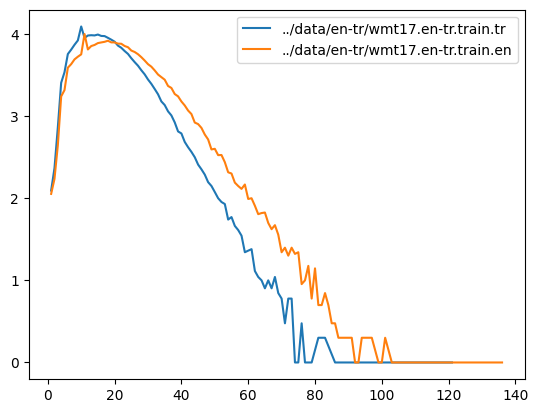

In [3]:
from collections import Counter
import matplotlib.pyplot as plt
import os
import math

with open("../data/en-tr/wmt17.en-tr.train.tr", 'r') as tr_f, open("../data/en-tr/wmt17.en-tr.train.en", 'r') as en_f:
    tr_data = tr_f.readlines()
    en_data = en_f.readlines()
tr_len = [len(s.split(" ")) for s in tr_data]
en_len = [len(s.split(" ")) for s in en_data]
en_len_counter = Counter(en_len)
def plot_len_fre_form_file(*path):
    """画出文件中句子的词的个数"""
    file_datas = []
    for p in path:
        assert os.path.exists(p)
        with open(p, 'r') as f:
            data = f.readlines()
        file_datas.append(data)
    def fn(s):
        l1 = len(s.split(" "))
        return l1 if l1 < 200 else 200
    sentence_len = [[fn(s) for s in data] for data in file_datas]
    len_counter = [Counter(s_len) for s_len in sentence_len]
    len_fre_item = [sorted(counter.items(), key=lambda x: x[0]) for counter in len_counter]       # 0是长度， 1是频次
    for item in len_fre_item:
        plt.plot([x[0] for x in item], [math.log10(x[1]) for x in item])
    plt.legend(path)
    plt.show()
plot_len_fre_form_file("../data/en-tr/wmt17.en-tr.train.tr", "../data/en-tr/wmt17.en-tr.train.en")

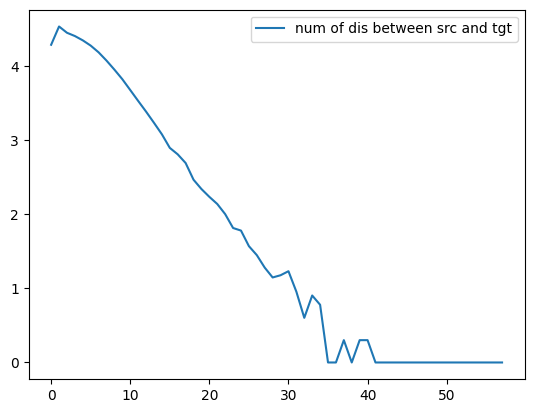

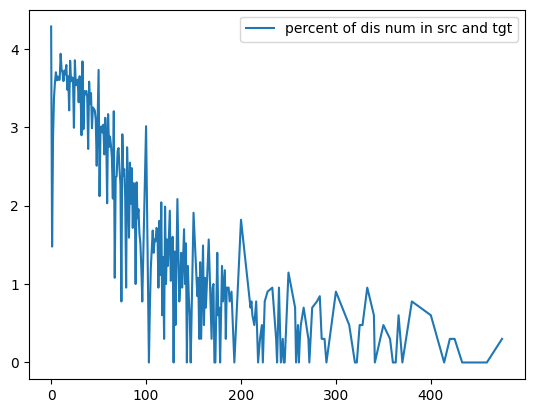

(4.170916036470382,
 (Counter({1: 33885,
           6: 15183,
           2: 27879,
           7: 11745,
           5: 18703,
           9: 6592,
           4: 22022,
           3: 25181,
           8: 8868,
           0: 19200,
           10: 4710,
           18: 291,
           13: 1703,
           12: 2410,
           14: 1192,
           20: 171,
           19: 218,
           11: 3360,
           16: 640,
           17: 489,
           22: 100,
           21: 137,
           15: 782,
           24: 60,
           38: 1,
           30: 17,
           26: 28,
           23: 65,
           27: 19,
           28: 14,
           39: 2,
           25: 37,
           37: 2,
           29: 15,
           57: 1,
           34: 6,
           31: 9,
           32: 4,
           41: 1,
           40: 2,
           33: 8,
           35: 1,
           46: 1,
           52: 1,
           36: 1}),
  Counter({20: 7020,
           66: 1597,
           10: 8611,
           11: 5451,
           41: 20

In [13]:
def get_len_dis(src_len, tgt_len):
    """统计src和tgt文件对应句子的长度差的绝对值的平均和分布"""
    
    len_dis = [abs(s-t) for s, t in zip(src_len, tgt_len)]
    counter = Counter(len_dis)
    item = sorted(counter.items(), key=lambda x: x[0])
    plt.plot([i[0] for i in item], [math.log10(i[1]) for i in item])
    plt.legend(["num of dis between src and tgt"])
    plt.show()
    
    len_dis_precent = [int((abs(s-t)/s)*100)  for s, t in zip(src_len, tgt_len)]        # 所差的个数占src句子的比例
    len_dis_precent = [p for p in len_dis_precent if p<500]                            # 去掉异常值
    counter_pre = Counter(len_dis_precent)
    item = sorted(counter_pre.items(), key=lambda x: x[0])
    plt.plot([i[0] for i in item], [math.log10(i[1]) for i in item])
    plt.legend(["percent of dis num in src and tgt"])
    plt.show()
    return sum(len_dis) / len(len_dis), (counter, counter_pre)

def get_sentence_len_from_file(src_p, tgt_p):
    with open(src_p, 'r') as src_f, open(tgt_p, "r") as tgt_f:
        src_data = src_f.readlines()
        tgt_data = tgt_f.readlines()
    src_len = map(lambda x: len(x.split(" ")), src_data)
    tgt_len = map(lambda x: len(x.split(" ")), tgt_data)
    return list(src_len), list(tgt_len)
src_len, tgt_len = get_sentence_len_from_file("../data/en-tr/wmt17.en-tr.train.tr", "../data/en-tr/wmt17.en-tr.train.en")
get_len_dis(src_len, tgt_len)

In [9]:
import torch
torch.load("../data/src-ref-pre-fl/ka-en-all/src_ref_pre.bin")[:10]

[{"src": "- მნჲდჲ?", "ref": "- Shut up, Ellie.", "pre": null, "cor": null},
 {"src": "- ჟკვნლყნ... მჲზვქ ლთ ეა დჲ გყპნვქ?", "ref": "Look, can you just give him his job back?", "pre": null, "cor": null},
 {"src": "- ჟათე.", "ref": "Sayid.", "pre": null, "cor": null},
 {"src": "ჰო, ნამდვილად.", "ref": "Yes, you really are.", "pre": null, "cor": null},
 {"src": "რჲგა ჟთ ვ ჟრპაქნთფკჲ.", "ref": "That's horrifying.", "pre": null, "cor": null},
 {"src": "ნვ დლვეა1⁄4 გჲ რგჲ1⁄4ჲრ გს1⁄4კჲ მჲმ÷ვ.", "ref": "Don't look to your uncle, boy.", "pre": null, "cor": null},
 {"src": "ნჲ წ ბსეს ჲფვნჩ ოჲ ნვი ჟკსფარჩ.", "ref": "Let's go to the kitchen.", "pre": null, "cor": null},
 {"src": "კჲოŠვმ კპჲჱ ჟპუვ.", "ref": "Lance through the heart.", "pre": null, "cor": null},
 {"src": "კჲი ბთ ოჲჟმწლ ეა ჟრყოთ გ რვჱთ ნვდჲჟრჲოპთვმნთ ჱვმთ?", "ref": "Who would dare set foot on this inhospitable summit?", "pre": null, "cor": null},
 {"src": "ჲელთ÷ნჲ, ოპთკაზვრვ 1⁄4ა ნა ვკპან.", "ref": "Perfect, put her on the screen", "

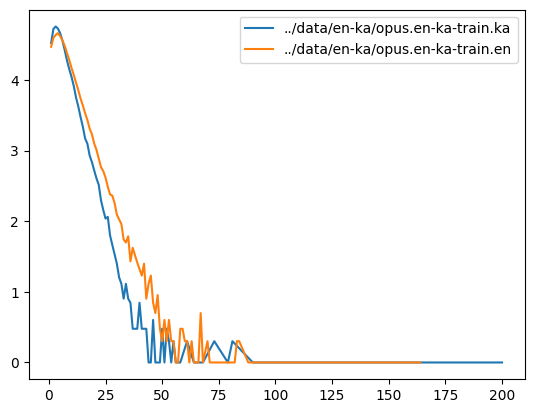

In [4]:
plot_len_fre_form_file("../data/en-ka/opus.en-ka-train.ka", "../data/en-ka/opus.en-ka-train.en")

# 利用反向翻译提升tr-en

过滤？ 单词数量少于10的句子

In [20]:
import torch
mono_trans = torch.load("../data/src-pre/tr-en-100000/src_ref_pre.bin")
print(len(mono_trans))

def filter_by_len(src, pre):
    l1 = len(pre.split(" "))
    l2 = len(src.split(" "))
    if l1 > 5 and l2 > 5:
        if abs(l1-l2) < 15:
            return True
    return False

len_mono_trans = [p for p in mono_trans if filter_by_len(p.src, p.pre)]
print(len(len_mono_trans))

100000
80582


In [22]:
len_mono_trans[:10]

[{"src": "Yabani meyve ağaçlarından düşen meyveleri yiyen yaban domuzlarını gördüğümüzde heyecanlanmıştık.", "ref": null, "pre": "We were excited when we saw wild pigs eating the fruits from wild berries.", "cor": null},
 {"src": "Gazze Şeridi'nde yüzde 16,5'le en yaygın görülen meme kanseriyken, onu sırasıyla kolon ve akciğer kanseri takip ediyor.", "ref": null, "pre": "Measuring 16.5 per cent in the Gaza Strip, breast cancer is the most common, followed by colon and lung cancer, respectively.", "cor": null},
 {"src": "Mevleviliğe mahsuz adapla kuşanan her bir semazenin giyinmesi yaklaşık 20 dakika sürüyor ve ustalık gerektiriyor.", "ref": null, "pre": "The dress of each of the ceremonial monks, dressed with an untouched pride, takes about 20 minutes and requires skill.", "cor": null},
 {"src": "Olağan Genel Kongresi'nde Selahattin Demirtaş ve Figen Yüksekdağ, 626 delegenin oy kullandığı seçimde, 624 oyla yeniden HDP eş genel başkanlığına seçildi.", "ref": null, "pre": "Selahattin Dem

In [23]:
path = "../data/en-tr/"
from transformers import DataCollatorForWholeWordMask
with open(os.path.join(path, "mono10w.en-tr.en"), 'w') as en_f, open(os.path.join(path, "mono10w.en-tr.tr"), "w") as tr_f:
    en_f.writelines([p.pre+"\n" for p in len_mono_trans])
    tr_f.writelines([p.src+"\n" for p in len_mono_trans])

# 试试调用nllb

In [6]:
from transformers import M2M100ForConditionalGeneration, AutoTokenizer

checkpoint = "/public/home/hongy/pre-train_model/nllb-200-distilled-600M"

model = M2M100ForConditionalGeneration.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model

M2M100ForConditionalGeneration(
  (model): M2M100Model(
    (shared): Embedding(256206, 1024, padding_idx=1)
    (encoder): M2M100Encoder(
      (embed_tokens): Embedding(256206, 1024, padding_idx=1)
      (embed_positions): M2M100SinusoidalPositionalEmbedding()
      (layers): ModuleList(
        (0): M2M100EncoderLayer(
          (self_attn): M2M100Attention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): ReLU()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerNorm((1024,)

In [7]:
tokenizer.tgt_lang = "kat_Geor"
tokenizer.src_lang = "eng_Latn"
tokenizer.src_lang, tokenizer.tgt_lang

('eng_Latn', 'kat_Geor')

In [3]:
with tokenizer.as_target_tokenizer():
    ka_text = "ნვ დლვეა1⁄4 გჲ რგჲ1⁄4ჲრ გს1⁄4კჲ მჲმ÷ვ."
    encoded = tokenizer(ka_text, return_tensors="pt", max_length=100, padding=True, truncation=True)
    print(tokenizer.batch_decode(encoded['input_ids']))

['kat_Geor ნვ დლვეა1⁄4 გჲ რგჲ1⁄4ჲრ გს1⁄4კჲ მჲმ÷ვ.</s>']


/public/home/hongy/hyxu/nmt-corrector/src/transformers/src/transformers/tokenization_utils_base.py:3596: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [11]:
tokenizer.convert_ids_to_tokens(256086)

'kat_Geor'

In [10]:
ka_text = "ნვ დლვეა1⁄4 გჲ რგჲ1⁄4ჲრ გს1⁄4კჲ მჲმ÷ვ."
en_text = ["Don't look at your loud boy.","i am a frg!"]
tokenizer(en_text, return_tensors="pt", max_length=100, padding=True, truncation=True)

{'input_ids': tensor([[256047,   8808, 248116, 248065,  15166,    230,   4260, 236022,  13755,
         248075,      2],
        [256047,     30,    259,      9,   1000, 248073, 248203,      2,      1,
              1,      1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]])}

In [5]:
from utils import compute_bleu
compute_bleu(["ds, 2w, grea"], [["ds w2, gera"]])

Tokenizer 'spm' has been changed to 'flores101', and may be removed in the future.
results is {'score': 6.567274736060395, 'counts': [1, 0, 0, 0], 'totals': [7, 6, 5, 4], 'precisions': [14.285714285714286, 8.333333333333334, 5.0, 3.125], 'bp': 1.0, 'sys_len': 7, 'ref_len': 4}


{'score': 6.567274736060395,
 'counts': [1, 0, 0, 0],
 'totals': [7, 6, 5, 4],
 'precisions': [14.285714285714286, 8.333333333333334, 5.0, 3.125],
 'bp': 1.0,
 'sys_len': 7,
 'ref_len': 4}

In [29]:
tokenizer.batch_decode(tokenizer(en_text, return_tensors="pt")['input_ids'])

["Don't look at your loud boy.</s>eng_Latn"]

In [15]:
with open("/public/home/hongy/pre-train_model/nllb-200-distilled-600M/generation_config.json", 'r') as f:
    data = f.readlines()
import json
data = json.loads(''.join(data))
data['f'] = 1
data

{'_from_model_config': True,
 'bos_token_id': 0,
 'decoder_start_token_id': 2,
 'eos_token_id': 2,
 'max_length': 200,
 'pad_token_id': 1,
 'transformers_version': '4.27.0.dev0',
 'f': 1}

In [34]:
generated_tokens = model.generate(**tokenizer(ka_text, return_tensors="pt"), forced_bos_token_id=tokenizer.lang_code_to_id["kat_Geor"])

/public/home/hongy/miniconda3/envs/hyxu_env/lib/python3.10/site-packages/transformers/generation/utils.py:1288: UserWarning: Using `max_length`'s default (200) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [35]:
tokenizer.batch_decode(generated_tokens)

['</s>kat_Geor ნვ ვ ნაპაგწრა ნა ნაპაგწრა.</s>']

In [14]:


hi_text = "जीवन एक चॉकलेट बॉक्स की तरह है।"
chinese_text = "sdsfdg235r 4tfgwat4T  U56UHJS巧克力。"
tokenizer.src_lang = "zh"
encoded_zh = tokenizer(ka_text, return_tensors="pt")
# generated_tokens = model.generate(**encoded_zh, forced_bos_token_id=tokenizer.lang_code_to_id["eng_Latn"])
generated_tokens = model.generate(**encoded_zh)
tokenizer.batch_decode(generated_tokens)[0]

In [13]:
tokenizer.convert_ids_to_tokens(2)

'</s>'

In [10]:
from transformers import MBartForConditionalGeneration, MBart50Tokenizer

checkpoint = "../checkpoint-nmt/ur-en-chpk/opus-dev/checkpoint-24000/"
model = MBartForConditionalGeneration.from_pretrained(checkpoint)
model

MBartForConditionalGeneration(
  (model): MBartModel(
    (shared): Embedding(250054, 1024, padding_idx=1)
    (encoder): MBartEncoder(
      (embed_tokens): Embedding(250054, 1024, padding_idx=1)
      (embed_positions): MBartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0): MBartEncoderLayer(
          (self_attn): MBartAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerN

In [11]:
tokenizer = MBart50Tokenizer.from_pretrained(checkpoint)
tokenizer

MBart50Tokenizer(name_or_path='../checkpoint-nmt/ur-en-chpk/opus-dev/checkpoint-24000/', vocab_size=250054, model_max_length=1024, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>', 'additional_special_tokens': ['ar_AR', 'cs_CZ', 'de_DE', 'en_XX', 'es_XX', 'et_EE', 'fi_FI', 'fr_XX', 'gu_IN', 'hi_IN', 'it_IT', 'ja_XX', 'kk_KZ', 'ko_KR', 'lt_LT', 'lv_LV', 'my_MM', 'ne_NP', 'nl_XX', 'ro_RO', 'ru_RU', 'si_LK', 'tr_TR', 'vi_VN', 'zh_CN', 'af_ZA', 'az_AZ', 'bn_IN', 'fa_IR', 'he_IL', 'hr_HR', 'id_ID', 'ka_GE', 'km_KH', 'mk_MK', 'ml_IN', 'mn_MN', 'mr_IN', 'pl_PL', 'ps_AF', 'pt_XX', 'sv_SE', 'sw_KE', 'ta_IN', 'te_IN', 'th_TH', 'tl_XX', 'uk_UA', 'ur_PK', 'xh_ZA', 'gl_ES', 'sl_SI']})

In [13]:
model.generation_config, tokenizer.src_lang, tokenizer.tgt_lang

(GenerationConfig {
   "_from_model_config": true,
   "bos_token_id": 0,
   "decoder_start_token_id": 2,
   "early_stopping": true,
   "eos_token_id": 2,
   "forced_eos_token_id": 2,
   "max_length": 200,
   "num_beams": 5,
   "pad_token_id": 1,
   "transformers_version": "4.27.4"
 },
 'ur_PK',
 'en_XX')

In [17]:
inputs = tokenizer.encode("123rfe23 233 re213r1", return_tensors="pt")
inputs

tensor([[250049,  37638,     42,   2242,   3742,      6, 105586,    456,    304,
           2681,     42,    418,      2]])

In [20]:

decoded = model.generate(inputs)
decoded

tensor([[     2, 250004,   2132,    420,      4,  59387,      4,   1215,    195,
              4,   2552,      5,      2]])

In [1]:
from typing import List
import torch
import os

from utils import SrcRefPreCor, create_logger, paras_filter_by_belu, compute_batch, avg
logger = create_logger("/public/home/hongy/hyxu/nmt-corrector/log/process_data_train_nmt.log")

def filter_fn(paras, r_p_bleu, r_c_bleu, return_bleu=False):
    """返回过滤后的SrcRefPreCor对,和对应的bleu, r_p_bleu在第二位， r_c_bleu在第三位"""
    data = [(paras[i], p_b, c_b) for i, (p_b, c_b) in enumerate(zip(r_p_bleu, r_c_bleu)) if c_b>5 and c_b>p_b-5]
    if return_bleu:
        return data
    else:
        return [p for p,pb,cb in data]
def clear_fn(paras: List[SrcRefPreCor], src_ref_pre_cor: List[SrcRefPreCor], is_filter=True):
    """清洗得到的cor，去掉两端多余回车和两端空格，去掉cor为空的数据
    计算ref与pre之间的bleu和ref与cor之间的bleu并返回，不过滤的话就不返回过滤的bleu
    
    Args:
        paras (List[SrcRefPreCor]): 需要处理的数据
        src_ref_pre_cor (List[SrcRefPreCor]): 将过滤后的数据存在此处
        is_filter (bool, optional): Defaults to True.是否过滤，过滤策略是filter_fn决定的

    Returns:
        _type_: bleu 如果过滤就还返回过滤的bleu
    """

    ref = [p.ref for p in paras if p.cor != None]
    pre = [p.pre for p in paras if p.cor != None]
    cor = [p.cor.lstrip(" ").lstrip('\n').rstrip("\n").rstrip(" ").replace("\n", "") for p in paras if p.cor!=None]
    r_p_bleu = compute_batch(ref=ref, pre=pre)
    r_c_bleu = compute_batch(ref=ref, pre=cor)
    # src_ref_pre_cor += [paras[i] for i, (p_b, c_b) in enumerate(zip(r_p_bleu, r_c_bleu)) if c_b>p_b]
    
    paras = [p for p in paras if p.cor!=None]
    for p, c in zip(paras, cor):                    #将干净的cor赋值给p
        p.cor = c
    
    if is_filter:
        data = filter_fn(paras, r_p_bleu, r_c_bleu, return_bleu=True)
        src_ref_pre_cor += [p for p,pb,cb in data]
        filter_p_bleu = [pb for p,pb,cb in data]
        filter_c_bleu = [cb for p,pb,cb in data]
        return r_p_bleu, r_c_bleu, filter_p_bleu, filter_c_bleu
    else:
        src_ref_pre_cor += paras
        return r_p_bleu, r_c_bleu

def process_data_from_dir(data_dir, is_filter=True, return_bleu=False):
    """data_dir 进程结果保存位置，clear_fn 清理函数"""
    file_prefix = 'thread'
    paras_prfix = 'paras-'
    total_r_p_bleu, total_r_c_bleu, filter_r_p_bleu, filter_r_c_bleu = [], [], [], [] 
    total_paras = []
    src_ref_pre_cor = []
    dir_list = os.listdir(data_dir)
    for i, p in enumerate(dir_list[:2]):
        if not p.startswith(file_prefix): continue
    
        id_thread = p[len(file_prefix):]
        logger.info(f"正在处理第{id_thread}个进程结果")
        paras_data = torch.load(os.path.join(data_dir, p, f"{paras_prfix}{id_thread}.bin"))
        total_paras += [p for p in paras_data if p.cor != None]
    
        result = clear_fn(paras_data, src_ref_pre_cor, is_filter)
        if is_filter:
            r_p_bleu, r_c_bleu, filter_p_bleu, filter_c_bleu = result
            filter_r_c_bleu += filter_c_bleu
            filter_r_p_bleu += filter_p_bleu
            logger.info(f"过滤后的pre平均bleu:{avg(filter_p_bleu)},  cor平均bleu:{avg(filter_c_bleu)}")
        else:
            r_p_bleu, r_c_bleu = result
        logger.info(f"pre平均bleu:{avg(r_p_bleu)},  cor平均bleu:{avg(r_c_bleu)}")
        total_r_p_bleu += r_p_bleu
        total_r_c_bleu += r_c_bleu
    logger.info(f"全部进程的总pre平均bleu:{avg(total_r_p_bleu)},  cor平均bleu:{avg(total_r_c_bleu)}")
    if return_bleu:
        return src_ref_pre_cor, total_paras, (total_r_p_bleu, total_r_c_bleu), (r_p_bleu, r_c_bleu)
    else:
        return src_ref_pre_cor, total_paras


In [2]:
pairs = "en-ka"
data_path = f"/public/home/hongy/hyxu/nmt-corrector/data/src-ref-pre-fl/ka-en-all/5-35"
save_path = f"/public/home/hongy/hyxu/nmt-corrector/data/{pairs}/"
src_ref_pre_cor , total_paras, total_bleu, filter_bleu = process_data_from_dir(data_path, True)

TypeError: 'enumerate' object is not subscriptable

In [ ]:
torch.save(total_paras, os.path.join(data_path, "total_paras.bin"))
torch.save(src_ref_pre_cor, os.path.join(data_path, "fliter_paras.bin"))
torch.save(total_bleu, os.path.join(data_path, "bleu.bin"))

In [ ]:
cor_data = [p.cor+'\n' for p in src_ref_pre_cor]
cor_src_data = [p.src+"\n" for p in src_ref_pre_cor]
cor_pre_data = [p.pre+"\n" for p in src_ref_pre_cor]
with open(os.path.join(save_path, f"cor8w.train.{pairs}.en"), "w") as e_f,  \
        open(os.path.join(save_path, f"cor8w.{pairs}.ka"), 'w') as k_f, \
        open(os.path.join(save_path, f"cor8w.pre.{pairs}.ka"), 'w') as pre_f: 
        e_f.writelines(cor_src_data)
        k_f.writelines(cor_data)
        pre_f.writelines(cor_pre_data)

NameError: name 'cor_src_data' is not defined

# 从ka-en的训练数据中随机抽出来100条句子

In [1]:
seed = 10
import random
import os
path = "../data/en-ka/"
en_data, ka_data = [], []
with open(os.path.join(path, "opus.en-ka-train.en"), 'r') as en_f,  \
    open(os.path.join(path, "opus.en-ka-train.ka"), 'r') as ka_f:
        en_data = en_f.readlines()
        ka_data = ka_f.readlines()
print(len(en_data))
indices = list(range(len(en_data)))
random.shuffle(indices)

377306


In [4]:
select_en, select_ka = [], []
for i in indices[:1000]:
    select_en.append(en_data[i])
    select_ka.append(ka_data[i])
len(select_ka), select_ka[:10], select_en[:10]

(1000,
 ['ფსჳ, ფვ ჟთ ჟვ ჲრბთლ გ ნაჟ.\n',
  'დლვეაი ეა ნვ სმპვქ.\n',
  '- ოპჲმვნთჳ ოყპგთწ ოაპადპატ.\n',
  'ოჲმთჟლთ თ ღვ...\n',
  'ბწჳ ჱავრ.\n',
  'სჟვღაქ ოპვჳგყპლწნვრჲ ნა ვნვპდთწ.\n',
  'ოპჲეჲლზთ ჟჲ ოჲევმჲრ, თ \x8dვ ეჲბთვქ ჟლჲბჲეა.\n',
  'ჲჟრალაჟჩ ლთქჩ ჲენა ბსრშლკა.\n',
  'თ ევკა ოთქსგა ჟ£ა£ნთ ოვჟნთ.\n',
  'ნაჟამ.\n'],
 ['I heard you stopped by my place.\n',
  "Don't get yourself killed.\n",
  'I changed the first paragraph.\n',
  "You think, and you'll...\n",
  'I was busy.\n',
  'You feel the transfer of the energy.\n',
  'Continue your ascent, and you will gain freedom.\n',
  "There's only this bottle left.\n",
  'Yeah. Play something, bro.\n',
  "It's here.\n"])

In [5]:
with open(os.path.join(path, "train.select1000.en"), 'w') as en_f,  \
    open(os.path.join(path, "train.select1000.ka"), 'w') as ka_f:
        en_f.writelines(select_en)
        ka_f.writelines(select_ka)

In [1]:
import math

In [5]:
math.pow(10, -0.1)

0.7943282347242815

In [6]:
import torch
from transformers import AutoModel, AutoTokenizer
path = "../chpk-nllb/en-ka-chpk/fldev-base/checkpoint-1000/"
model = AutoModel.from_pretrained(path)
tokenizer = AutoTokenizer.from_pretrained(path)
model, tokenizer

Some weights of the model checkpoint at ../chpk-nllb/en-ka-chpk/fldev-base/checkpoint-1000/ were not used when initializing M2M100Model: ['lm_head.weight']
- This IS expected if you are initializing M2M100Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing M2M100Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


(M2M100Model(
   (shared): Embedding(256206, 1024, padding_idx=1)
   (encoder): M2M100Encoder(
     (embed_tokens): Embedding(256206, 1024, padding_idx=1)
     (embed_positions): M2M100SinusoidalPositionalEmbedding()
     (layers): ModuleList(
       (0): M2M100EncoderLayer(
         (self_attn): M2M100Attention(
           (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
           (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
           (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
           (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
         )
         (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
         (activation_fn): ReLU()
         (fc1): Linear(in_features=1024, out_features=4096, bias=True)
         (fc2): Linear(in_features=4096, out_features=1024, bias=True)
         (final_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
       )
       (1): 

In [15]:
text = "Nice to meet you!"
encoded = tokenizer(text, text_target="Nice to meet you too!", return_tensors="pt")
encoded['decoder_input_ids'] = encoded.pop("labels")
encoded

{'input_ids': tensor([[256047,  89880,    202,  17334,   1259, 248203,      2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]]), 'decoder_input_ids': tensor([[256086,  89880,    202,  17334,   1259,   8872, 248203,      2]])}

In [25]:

output = model(**encoded)
output

Seq2SeqModelOutput(last_hidden_state=tensor([[[ 5.1955e-02, -3.5321e-01, -2.8431e+00,  ...,  2.1266e+00,
          -5.5072e-01, -8.7330e-03],
         [-1.1591e-01,  9.3612e-01, -3.8505e+00,  ...,  3.2648e+00,
           8.6176e-02, -1.2525e-01],
         [ 2.1962e-01,  1.5653e+00, -4.9444e+00,  ...,  3.4017e+00,
           2.0061e-01, -1.3790e-01],
         ...,
         [ 2.6925e-04,  2.1877e+00, -4.9420e+00,  ...,  3.4290e+00,
           2.8535e-01, -1.0251e-03],
         [-9.6358e-02,  2.2650e+00, -4.9861e+00,  ...,  3.8616e+00,
           1.6910e-01,  1.4222e-01],
         [-6.0673e-02,  2.3505e+00, -4.9655e+00,  ...,  3.1959e+00,
           4.1577e-01,  9.5463e-02]]], grad_fn=<NativeLayerNormBackward0>), past_key_values=((tensor([[[[-1.6405, -0.5952,  2.3129,  ...,  1.8159, -0.4980, -1.5651],
          [-0.8762, -0.4131,  0.2329,  ..., -0.0069, -0.2291, -0.4110],
          [ 0.2285,  0.3067, -0.2437,  ..., -0.8319,  0.1382,  0.4896],
          ...,
          [-0.9276, -0.7008,  0

In [26]:
output = output["last_hidden_state"]
output.squeeze_(dim=0)
output.shape

torch.Size([8, 1024])

In [31]:
values, indices = output.topk(3)
values.requires_grad, values, indices

(True,
 tensor([[3.2520, 2.3528, 2.1266],
         [4.3528, 3.2648, 3.1881],
         [4.0135, 3.4017, 3.2364],
         [4.1204, 3.2769, 3.2432],
         [4.1166, 3.3573, 3.2105],
         [3.9546, 3.4290, 3.3564],
         [4.1851, 3.8616, 3.6157],
         [3.8472, 3.1959, 3.0700]], grad_fn=<TopkBackward0>),
 tensor([[ 852,  812, 1021],
         [ 852, 1021,  812],
         [ 852, 1021,  812],
         [ 852,  812, 1021],
         [ 852, 1021,  812],
         [ 852, 1021,  812],
         [ 852, 1021,  812],
         [ 852, 1021,  812]]))

In [36]:
for top_f, top_l in zip(values[:,:2], values[:,1:]):
    loss = -top_l*torch.log(top_f)
loss.sum(), len(loss)

(tensor(-7.8730, grad_fn=<SumBackward0>), 2)

# 看看数据到底是怎么回事

In [26]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, MBartForConditionalGeneration
checkpoint = "../../../pre-train_model/mbart-large-50/"
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model, tokenizer

(MBartForConditionalGeneration(
   (model): MBartModel(
     (shared): Embedding(250054, 1024, padding_idx=1)
     (encoder): MBartEncoder(
       (embed_tokens): Embedding(250054, 1024, padding_idx=1)
       (embed_positions): MBartLearnedPositionalEmbedding(1026, 1024)
       (layers): ModuleList(
         (0): MBartEncoderLayer(
           (self_attn): MBartAttention(
             (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
             (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
             (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
             (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
           )
           (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
           (activation_fn): GELUActivation()
           (fc1): Linear(in_features=1024, out_features=4096, bias=True)
           (fc2): Linear(in_features=4096, out_features=1024, bias=True)
           (final_

In [27]:
file_path = "../data/en-ur/cor20w.mono.en-ur.ur"
ur_data = []
with open(file_path, 'r') as f:
    ur_data = f.readlines()
len(ur_data), ur_data[:10]

(199945,
 ['چیف جسٹس نے سانحہ ماڈل ٹاون متاثرین کو انصاف میں تاخیر کا نوٹس لے لیا\n',
  'پاکستان کی تاریخ میں پہلی بار خواجہ سرا کمیونٹی کی تعلیم اور پیشہ ورانہ تربیت کے لیے قائم کیے جانے والے اسکول کا لاہور میں 15 اپریل سے آغاز ہوگا۔\n',
  '’دی جینڈر گارڈین‘ نامی اس اسکول میں خواجہ سراؤں کو پرائمری سے انٹرمیڈیٹ تک کی 12 سالہ تعلیم دی جائے گی۔\n',
  'خواجہ سراؤں کے اس اسکول کی پہلی برانچ ماڈل ٹاؤن لاہور میں، دوسری برانچ اسلام آباد میں اور تیسری برانچ کراچی میں بنائی جائیں گی۔\n',
  'انتظامیہ کے مطابق خواجہ سرا برادری کے 40 سے زائد خواہشمند طلبہ اسکول کے آغاز سے قبل ہی اپنی رجسٹریشن کرا چکے ہیں۔\n',
  'اسکول کی افتتاحی تقریب قذافی اسٹیڈیم لاہور کے الحمرا ہال میں منعقد ہوگی جس میں ملک کے نامور فنکار شرکت کریں گے۔\n',
  'دبئی: مشہور و معروف بھارتی اداکارہ سری دیوی دل کا دورہ پڑنے سے 54 سال کی عمر میں دبئی میں انتقال کر گئیں۔\n',
  'معروف اداکارہ کا اصل نام شری اما ینگر ایاپن تھا اور انہوں نے چائلڈ آرٹسٹ کی حیثیت سے اپنے کیریئر کا آغاز کیا اور 1978 میں بالی وڈ میں ڈیبیو سے قبل تامل، تیلگو،

In [29]:
encoded = tokenizer.encode(ur_data[34])
decoded = tokenizer.decode(encoded)
encoded, tokenizer.tokenize(ur_data[34]), decoded,ur_data[34]

([250004,
  878,
  47900,
  50,
  20164,
  13279,
  3685,
  18189,
  24957,
  219745,
  20438,
  163391,
  12947,
  3755,
  216,
  8617,
  6,
  21148,
  24440,
  163391,
  288,
  20882,
  504,
  4481,
  878,
  577,
  431,
  13859,
  220328,
  12692,
  145728,
  523,
  136112,
  1468,
  6,
  2],
 ['▁ا',
  'ٹک',
  '،',
  '▁سابق',
  '▁ایم',
  '▁پی',
  '▁اے',
  '▁سید',
  '▁اعجاز',
  '▁حسین',
  '▁بخاری',
  '▁عمران',
  '▁خان',
  '▁کے',
  '▁دوست',
  '▁',
  'زل',
  'فی',
  '▁بخاری',
  '▁کی',
  '▁وجہ',
  '▁سے',
  '▁اپنے',
  '▁ا',
  'ُ',
  'و',
  'پر',
  '▁لگائے',
  '▁گئے',
  '▁الزامات',
  '▁پر',
  '▁پریس',
  '▁..',
  '▁'],
 'en_XX اٹک، سابق ایم پی اے سید اعجاز حسین بخاری عمران خان کے دوست زلفی بخاری کی وجہ سے اپنے اُوپر لگائے گئے الزامات پر پریس.. </s>',
 'اٹک، سابق ایم پی اے سید اعجاز حسین بخاری عمران خان کے دوست زلفی بخاری کی وجہ سے اپنے اُوپر لگائے گئے الزامات پر پریس ..\n')

In [47]:
decoded, decoded.replace("▁", " "),ur_data[34]

('▁اٹک،▁سابق▁ایم▁پی▁اے▁سید▁اعجاز▁حسین▁بخاری▁عمران▁خان▁کے▁دوست▁زلفی▁بخاری▁کی▁وجہ▁سے▁اپنے▁اُوپر▁لگائے▁گئے▁الزامات▁پر▁پریس▁..',
 ' اٹک، سابق ایم پی اے سید اعجاز حسین بخاری عمران خان کے دوست زلفی بخاری کی وجہ سے اپنے اُوپر لگائے گئے الزامات پر پریس ..',
 'اٹک، سابق ایم پی اے سید اعجاز حسین بخاری عمران خان کے دوست زلفی بخاری کی وجہ سے اپنے اُوپر لگائے گئے الزامات پر پریس ..\n')

# 从helsinki 得到的 mono20w抽取出来一千条测试一下

In [3]:

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, MBartForConditionalGeneration, Seq2SeqTrainer
import os
from tqdm import tqdm
checkpoint = "../checkpoint-nmt/ur-en-chpk-bug/opus-dev/checkpoint-24000"
model = MBartForConditionalGeneration.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model, tokenizer

(MBartForConditionalGeneration(
   (model): MBartModel(
     (shared): Embedding(250054, 1024, padding_idx=1)
     (encoder): MBartEncoder(
       (embed_tokens): Embedding(250054, 1024, padding_idx=1)
       (embed_positions): MBartLearnedPositionalEmbedding(1026, 1024)
       (layers): ModuleList(
         (0): MBartEncoderLayer(
           (self_attn): MBartAttention(
             (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
             (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
             (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
             (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
           )
           (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
           (activation_fn): GELUActivation()
           (fc1): Linear(in_features=1024, out_features=4096, bias=True)
           (fc2): Linear(in_features=4096, out_features=1024, bias=True)
           (final_

In [3]:
import os
file_path = "../checkpoint-nmt/ur-en-chpk-bug/opus-dev/checkpoint-24000/"
pre_data, ref_data = [], []
with open(os.path.join(file_path, "predictions.txt"), 'r') as f:
    pre_data = f.readlines()
with open(os.path.join(file_path, "references.txt"), 'r') as f:
    ref_data = f.readlines()
len(pre_data),len(ref_data), pre_data[:3], ref_data[:3]

(2000,
 2000,
 ['I am quit of it. I desire only to strengthen the people of the city. I shall do so for an appointed time.\n',
  '“He is the son of my mother and the son of my maternal uncles.”\n',
  'Those who responded to the call of God and the Messenger after injury had smitten them—for the righteous among them is a great reward.\n'],
 ["My 50 hours of community service meant cleaning a city I didn't care about.\n",
  "UM, HE'S MY MOM'S BOYFRIEND.\n",
  'Those [believers] who responded to Allah and the Messenger after injury had struck them. For those who did good among them and feared Allah is a great reward -\n'])

In [ ]:
tokenizer.pad_token_id

In [ ]:
from utils import compute_bleu
bleu = []
predictions = []
for src_text, tgt_text in tqdm(list(zip(ur_data, en_data))):
    encoded = tokenizer(src_text, max_length=128, padding=True, truncation=True, return_tensors="pt")
    outputs = model.generate(**encoded)
    txt = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    bleu.append(compute_bleu(txt, tgt_text)['score'])
    predictions.append(txt)

In [5]:
src_text, tgt_text = ur_data[10:20], en_data[10:20]
encoded = tokenizer(src_text, max_length=128, padding=True, truncation=True, return_tensors="pt")
encoded, tokenizer.batch_decode(encoded['input_ids'])

({'input_ids': tensor([[250049,   4660,   3485,  ...,      1,      1,      1],
         [250049,  15122,  13267,  ...,      1,      1,      1],
         [250049,   3662,    216,  ...,      1,      1,      1],
         ...,
         [250049,   3456,   1938,  ...,      1,      1,      1],
         [250049,  15122,  13267,  ...,      1,      1,      1],
         [250049,    490,   5249,  ...,   5676,   7122,      2]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1]])},
 ['ur_PK جس وقت جشن کی تقاریب چل رہی تھیں تب اس پر گاہے بگاہے تبصرے آتے رہے۔ </s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

In [6]:
outputs = model.generate(**encoded)
outputs

/public/home/hongy/miniconda3/envs/hyxu_env/lib/python3.10/site-packages/transformers/generation_utils.py:1359: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 200 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


tensor([[     2, 250004,  14847,  ...,      1,      1,      1],
        [     2, 250004,    360,  ...,      1,      1,      1],
        [     2, 250004,     15,  ...,      1,      1,      1],
        ...,
        [     2, 250004,  28129,  ...,      1,      1,      1],
        [     2, 250004,    360,  ...,      1,      1,      1],
        [     2, 250004,   8622,  ...,  23902,      5,      2]])

In [7]:
tokenizer.batch_decode(outputs, skip_special_tokens=True), tgt_text

(['When they were wont to sing the praises of the (holy) Favour of their Lord, lo! there came to them widespread (disbelief in the Oneness of Allah Islamic Monotheism).',
  'In parchment unrolled.',
  '(It will be) a cup full of wine,',
  'What is the Indubitable?',
  'In (the city of) Al-Madinah (there is) a great shrinking and a great shrinking,- (there is) a great shrinking,- (there is) a great shrinking,- (there is) a great shrinking,- (there is a great shrinking).',
  'And when Jesus sensed their disbelief, he said, “Who will be my helpers in the cause of God?” The disciples said, “We are the helpers of God; we believe in God, and you bear witness that we submit.”',
  'Those who are humble in their prayers.',
  'Had it not been for what their hands had forwarded, they would have said, "Our Lord, why did You not send us an apostle so that we might have followed Your signs and been among the believers?"',
  'In parchment unrolled.',
  'There is no blame on the blind, nor any blame o

In [8]:
from utils import compute_bleu
compute_bleu(predictions=pre_data, references=[r for r in ref_data])

results is {'score': 23.40389551097667, 'counts': [21459, 11122, 6833, 4444], 'totals': [42483, 40483, 38484, 36497], 'precisions': [50.51196949367983, 27.473260380900626, 17.755430828396218, 12.176343261089952], 'bp': 1.0, 'sys_len': 42483, 'ref_len': 42447}


{'score': 23.40389551097667,
 'counts': [21459, 11122, 6833, 4444],
 'totals': [42483, 40483, 38484, 36497],
 'precisions': [50.51196949367983,
  27.473260380900626,
  17.755430828396218,
  12.176343261089952],
 'bp': 1.0,
 'sys_len': 42483,
 'ref_len': 42447}

In [4]:
from utils import compute_batch, avg
from tqdm import tqdm
bleu = compute_batch(ref_data, pre_data)
avg(bleu)

2000it [00:12, 161.19it/s]


15.960300311642648

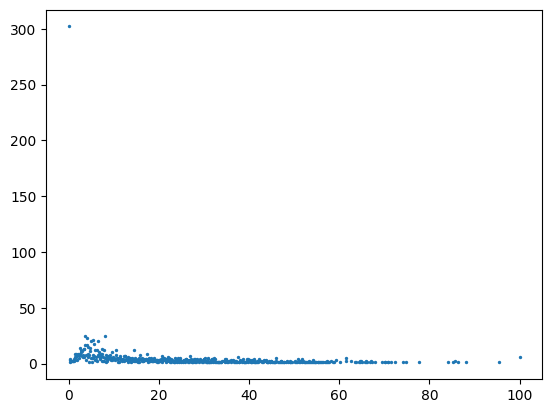

In [6]:
import matplotlib.pyplot as plt
from collections import Counter
count_bleu = [int(b*10)/10 for b in bleu]
counter = Counter(count_bleu)
count_bleu = sorted(counter.items(), key=lambda x: x[0])            #按照大小排个序
plt.scatter([b[0] for b in count_bleu], [b[1] for b in count_bleu], s=2)

In [9]:
high_bleu = [i for i,b in enumerate(bleu) if b>16]
high_ex = [(ref_data[i], pre_data[i]) for i in high_bleu]
len(high_ex), high_ex[:10]

(732,
 [('Those [believers] who responded to Allah and the Messenger after injury had struck them. For those who did good among them and feared Allah is a great reward -\n',
   'Those who responded to the call of God and the Messenger after injury had smitten them—for the righteous among them is a great reward.\n'),
  ('He created man\n', 'He created man,\n'),
  ('She said, “Alas for me. Shall I give birth, when I am an old woman, and this, my husband, is an old man? This is truly a strange thing.”\n',
   'She said, ‘Woe to me! Shall I bear a child, when I am an old woman, and my husband is an old man? Indeed this is a strange thing!’\n'),
  ('It is most hateful in the sight of God if you say something and do not practice it.\n',
   'It is most hateful in the sight of Allah that you should say what you do not do.\n'),
  ('And fear the Day (of Judgement) when no person shall avail another, nor shall compensation be accepted from him, nor shall intercession be of use to him, nor shall th

In [11]:
low_bleu = [i for i,b in enumerate(bleu) if b<=1]
low_ex = [(ref_data[i], pre_data[i]) for i in low_bleu]
len(low_ex), low_ex[:10]

(316,
 [('paper size\n', 'In parchment unrolled.\n'),
  ('paper size\n', 'In parchment unrolled.\n'),
  ('Woe, that Day, to those who deny [(Allah, His Angels, His Books, His Messengers, the Day of Resurrection, and Al-Qadar (Divine Preordainments)].\n',
   'Woe to the deniers on that day!\n'),
  ('WHAT YOU AND YOUR DAD HAVE.\n', 'Indeed, you love Me,\n'),
  ('Extraction not performed\n',
   'None will be questioned about the Day of Resurrection.\n'),
  ('- The king, marched the market one day, and he...\n',
   '"How then can you become a freeman?"\n'),
  ('Ademar?\n', 'Alif, Lam, Meem.\n'),
  ('Mother, I will not fear Mother, I will not become you. Jurrat invites peoples on the streets of Delhi on 16th December and part of their campaign.\n',
   'So he invented the name of Mecca.\n'),
  ('paper size\n', 'In parchment unrolled.\n'),
  ('paper size\n', 'In parchment unrolled.\n')])

In [ ]:
from transformers import DataCollatorForSeq2Seq

# 处理ur-en的单语数据

In [15]:
import os
import re
path = "../data/mono/ur/"
with open(os.path.join(path, "ur.txt"), "r") as f:
    mono_data = f.readlines()
len(mono_data)

27951610

In [17]:

def count_azb(text):
    pattern = re.compile(r'[^\u0600-\u06FF\u0750-\u077F\uFB50-\uFDFF\uFE70-\uFEFF\s]')

# 计算匹配到的字符数量
    r_azb_count = len(re.findall(pattern, text))
    # symbol_count = len(re.findall(r'[^\u4e00-\u9fa5\uFF00-\uFFEF\s\w]', text))
    return r_azb_count
count_azb("ان سب احادیث کو امام مسلم نے روایت کیا ہے (134)")

5

In [16]:
mono_data = [d.replace("\n", " ").lstrip(" ").rstrip(" ") for d in mono_data]

len(mono_data)

(27951610, 18011556)

In [22]:
sentences = [d for d in mono_data if 45>len(d.split(" ")) > 10]
len(sentences)

11278519

In [23]:
results_sentences = [s for s in sentences if count_azb(s)/len(s) < 0.1]

In [24]:
len(results_sentences), results_sentences[:10]

(10337108,
 ['چیف جسٹس نے سانحہ ماڈل ٹاون متاثرین کو انصاف میں تاخیر کا نوٹس لے لیا',
  'لاہور(کورٹ رپورٹر) چیف جسٹس پاکستان میاں ثاقب نثار نے سانحہ ماڈل ٹاو\x04¿ن متاثرین کو انصاف کی فراہمی میں تاخیر کا نوٹس لیتے ہوئے کہا کہ انصاف ملے گا میرے ہوتے ہوئے ڈرنے کی ضرورت نہیں۔',
  'پاکستان کی تاریخ میں پہلی بار خواجہ سرا کمیونٹی کی تعلیم اور پیشہ ورانہ تربیت کے لیے قائم کیے جانے والے اسکول کا لاہور میں 15 اپریل سے آغاز ہوگا۔',
  '’دی جینڈر گارڈین‘ نامی اس اسکول میں خواجہ سراؤں کو پرائمری سے انٹرمیڈیٹ تک کی 12 سالہ تعلیم دی جائے گی۔',
  'اس کے علاوہ خواجہ سرا برادری کے افراد اسکول سے ٹیکنکل تعلیم یعنی فیشن ڈیزائننگ، بیوٹیشن، ہیئر اسٹائلنگ، کڑھائی، موبائل و کمپیوٹر ریپئرنگ، گرافکس ڈیزائننگ، کمپیوٹر بیسک ایپلیکیشن اور دیگر کورسز کی تعلیم بھی حاصل کر سکیں گے۔',
  'اسکول کے بانی آصف شہزاد نے ڈان نیوز سے گفتگو کے دوران بتایا کہ یہ اسکول ’ایکسپلورنگ فیوچر ایجوکیشن‘ نامی غیر سرکاری تنظیم (این جی او) کے اشتراک سے بنایا جائے گا۔',
  'خواجہ سراؤں کے اس اسکول کی پہلی برانچ ماڈل ٹاﺅن لاہور میں، دوسری ب

In [25]:
results_sentences = [s+"\n" for s in results_sentences[2000000:3000000]]
with open("../data/mono/ur/100w-filter.ur", 'w') as f:
    f.writelines(results_sentences)

# 

In [3]:
import torch

data = torch.load("../data/src-ref-pre/ka-en/ka-en-all/process/fliter_paras.bin")
len(data), data[:10]

(29300,
 [{"src": "კჲი ბთ ოჲჟმწლ ეა ჟრყოთ გ რვჱთ ნვდჲჟრჲოპთვმნთ ჱვმთ?", "ref": "Who would dare set foot on this inhospitable summit?", "pre": "Who would dare step foot in these unforgivable lands?", "cor": "Who would dare set foot in these unforgiving lands?"},
  {"src": "დლვეამ ევკა ჲგა ვ ნვგვპჲ£არნჲ ჱაჟპამსგაფკა ჟთრსაუთ£ა ჱა რვბვ", "ref": "I can see this is an incredibly embarrassing situation for you.", "pre": "I see that this is an unprecedented embarrassing situation for you", "cor": "I see that this is an unprecedentedly embarrassing situation for you."},
  {"src": "ბაპთ, მჲდა ეა რვ ოპთნსეწ ეა დჲ კაზვქ.", "ref": "Barry, I can make you say it.", "pre": "Barry, I can get you to say this.", "cor": "Barry, I can make you say this."},
  {"src": "სერვერის (% 1) სერვტიფიკატმა ავტორიზაციის ტესტი ჩააგდო.", "ref": "The server (%1) certificate failed the authenticity test. %2", "pre": "Server (%1) has successfully completed authentication test.", "cor": "Server (%1) has successfully complet

In [16]:
import torch
import os

path = "/public/home/hongy/hyxu/nmt-corrector/data/src-ref-pre/ka-en/ka-en-all/process"
paras = torch.load(os.path.join(path, "total_paras.bin"))
bleu = torch.load(os.path.join(path, "bleu.bin"))
len(paras), len(bleu)

(41725, 2)

In [17]:
len(bleu[0]), len(bleu[1]), bleu[0][:10], bleu[1][:10]

(41725,
 41725,
 [17.747405280050266,
  23.462350320527996,
  32.99292579001791,
  30.213753973567687,
  21.241494252828044,
  13.147601201284163,
  20.448007360218387,
  29.53872020786076,
  13.832283585102266,
  21.34638973666068],
 [41.11336169005198,
  18.04438612975343,
  44.833867003844574,
  75.06238537503395,
  22.17994592198391,
  12.929367642051732,
  11.114924776032012,
  19.331263581394154,
  14.334389232407714,
  9.671235942361175])

In [18]:
def p_len(s, t):
    l1 = len(s.split(" "))
    l2 = len(t.split(" "))
    return abs(l1-l2) / l1 < 3
paras = [p for p in paras if p_len(p.pre, p.cor)]
print(len(paras))
def fn(s):
    s = s.replace("\n", " ").lstrip(" ").rstrip(" ")
    return s
t_d = [fn(p.cor)+"\n" for p in paras]
with open("../data/en-ka/total5w.train.en-ka.en", "w") as t_f:
    t_f.writelines(t_d)
s_d = [fn(p.src)+"\n" for p in paras]
with open("../data/en-ka/total5w.train.en-ka.ka", "w") as t_f:
    t_f.writelines(s_d)
pre_d = [fn(p.pre)+"\n" for p in paras]
with open("../data/en-ka/total5w.pre.train.en-ka.en", "w") as t_f:
    t_f.writelines(pre_d)

41675


In [21]:
data = []
with open("../data/en-ka/5w.pre.train.en-ka.en") as f:
    data = f.readlines()
print(len(data))
with open("../data/en-ka/opus.en-ka-train.en") as f:
    data += f.readlines()
print(len(data))
with open("../data/en-ka/train_cor/pre40w.en-ka.en", "w") as f:
    f.writelines(data)

29300
406606


In [23]:
import torch
import os
path = "../data/src-ref-pre/tr-en-200000/"

data = torch.load(os.path.join(path, "src_ref_pre.bin"))
len(data)

200000

In [24]:
with open("../data/en-tr/wmt17.en-tr.train.en") as f:
    en_data = f.readlines()
len(en_data)

205756

# 将sl-en的opus test 保存下来

In [26]:
with open("../data/en-sl/opus.en-sl-test.en") as f:
    en_data = f.readlines()
with open("../data/en-sl/opus.en-sl-test.sl") as f:
    sl_data = f.readlines()
len(en_data), len(sl_data)

(2000, 2000)

In [28]:
from utils import SrcRefPreCor
sl_data = [s.rstrip("\n").lstrip(" ").rstrip(" ") for s in sl_data]
en_data = [s.rstrip("\n").lstrip(" ").rstrip(" ") for s in en_data]
src_ref_pre = [SrcRefPreCor(src=s,ref=r) for s, r in zip(sl_data, en_data)]
len(src_ref_pre), src_ref_pre[:10]

(2000,
 [{"src": "Dva sta z njim.", "ref": "Two guys are with him.", "pre": null, "cor": null},
  {"src": "Lahko vsaj oblečem majico?", "ref": "Can't I at least put a T-shirt on? Yeah, please.", "pre": null, "cor": null},
  {"src": "Mislim, da ne želite nadaljevati s tem na sodišču.", "ref": "I don´t think court is where you want to go with this.", "pre": null, "cor": null},
  {"src": "Počeši mi lase.", "ref": "Comb my hair?", "pre": null, "cor": null},
  {"src": "Ji lahko vsaj odnesete moje sporočilo? Denar?", "ref": "Could you at least take her a message for me or maybe some money?", "pre": null, "cor": null},
  {"src": "Country glasba je bolna.", "ref": "- Country music records are ill.", "pre": null, "cor": null},
  {"src": "Mislim, da sem našla njegov želodec.", "ref": "I think I found his stomach.", "pre": null, "cor": null},
  {"src": "Stari Gospod grdo govori o Shug.", "ref": "Old Mister talking trash about Shug.", "pre": null, "cor": null},
  {"src": "-Bi te, če niso odveč.", 

In [29]:
torch.save(src_ref_pre, "../data/en-sl/opus-sl-en-test.bin")

## 过滤sl-en中比较短的句子

In [30]:
with open("../data/en-sl/opus.en-sl-train.en") as f:
    en_data = f.readlines()
with open("../data/en-sl/opus.en-sl-train.sl") as f:
    sl_data = f.readlines()
len(en_data), len(sl_data)

(1000000, 1000000)

In [33]:
def fn(s):
    l1 = len(s.split(" "))
    return l1>4
trans_paras = [(s, t) for s, t in zip(sl_data, en_data) if fn(s) and fn(t)]
len(trans_paras), trans_paras[:10]

(463606,
 [('Terapijo mora izvajati zdravnik, ki že ima izkušnje z zdravljenjem okužbe z virusom HIV.\n',
   'Therapy should be initiated by a physician experienced in the management of HIV infection.\n'),
  ('Jaz želim biti perverzni doktor.\n', 'I want to be the pervy doctor.\n'),
  ('Hej, očka! Pridite z menoj!\n', 'Hey, Daddy, come with me.\n'),
  ('S tem bomo omogočili nadaljevanje poskusov in dokazovanja znanstvene vrednosti.\n',
   'This will allow the sibling trial to proceed for its purely scientific value.\n'),
  ('- Vse teče od mene.\n', "I feel like I'm leaking.\n"),
  ('Ja, samo naj nekoga pokličem, prav?\n',
   'yea, let me just fetch someone okay\n'),
  ('Menda izhaja iz njegove raziskave vita-sevanja.\n',
   'Supposedly, it has its roots in his work with vita-radiation.\n'),
  ('Absorpcija Absorpcijske lastnosti so rezultat tega, da je zdravilo mešanica insulinskih zdravil s hitro in podaljšano absorpcijo.\n',
   'Absorption The absorption profile is due to the product 

In [35]:
with open("../data/en-sl/filter.en-sl.en", "w") as f:
    f.writelines([p[1] for p in trans_paras])
with open("../data/en-sl/filter.en-sl.sl", "w") as f:
    f.writelines([p[0] for p in trans_paras])

In [36]:
from utils import compute_batch

data = torch.load("../data/src-ref-pre/sl-en-all/src_ref_pre.bin")
len(data)

463606

In [39]:
bleu = compute_batch(ref=[p.ref for p in data], pre=[p.pre for p in data])
len(bleu), sum(bleu)/len(bleu)

  0%|          | 60/463606 [01:02<133:34:21,  1.04s/it]


KeyboardInterrupt: 

In [41]:
import os
path = "../data/en-sl/"
s_data, t_data = [], []
with open(os.path.join(path, "25w.train.en-sl.en")) as f:
    t_data += f.readlines()
with open(os.path.join(path, "25w.train.en-sl.sl")) as f:
    s_data += f.readlines()
with open(os.path.join(path, "opus.en-sl-train.en")) as f:
    t_data += f.readlines()
with open(os.path.join(path, "opus.en-sl-train.sl")) as f:
    s_data += f.readlines()
    
with open(os.path.join(path, "total.en-sl.sl"), "w") as f:
    f.writelines(s_data)
with open(os.path.join(path, "total.en-sl.en"), "w") as f:
    f.writelines(t_data)


len(s_data), len(t_data)

(1143436, 1143436)